In [37]:
# importing libraries
from sklearn.datasets import make_blobs
import os, matplotlib.pyplot as plt, pandas as pd, psycopg2, numpy as np
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import Bidirectional, Conv1D, MaxPooling1D, Flatten, SpatialDropout1D
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.layers import concatenate
from numpy import dstack, argmax
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.layers import Input
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


In [38]:
os.chdir(r'C:/Users/a0056407/Desktop/DeepLearning')

In [39]:
print('reading the dataset, please wait...')
conn = psycopg2.connect(user="postgres", password="postgres",
                                  host="127.0.0.1", port="5432", database="mike")
cursor = conn.cursor()
sql_cmd1 = "select id, icdmain_consensus, disease_description from verbal_autopsy"
#sql_cmd2 = "select id, icdmain_consensus from verbal_autopsy"
cursor.execute(sql_cmd1)
#cursor.execute(sql_cmd2)
dfA = pd.read_sql(sql_cmd1, conn)
#df2 = pd.read_sql(sql_cmd2, conn)
#closing the connection
cursor.close()
conn.close()
print('data read successfully and connection closed...')

print('merge the two datasets...')
#dfA = pd.merge(df1, df2, on='id')
dfA.loc[dfA['icdmain_consensus'].isnull(), 'icdmain_consensus'] = ''
dfA = dfA.dropna(subset=['disease_description'])

print(len(dfA))
print(dfA.head())

reading the dataset, please wait...
data read successfully and connection closed...
merge the two datasets...
14079
       id icdmain_consensus                                disease_description
0  100012               B20  Deceased started to ill while at working place...
1  100018               B20  The deceased developed blisters under the righ...
2  100077                99  He was having  a painful penis. His body was h...
3  100078               B20  At first the deceased was complaining about br...
4  100094                    He started by coughing and have difficulty in ...


In [40]:
print('drop nulls...')
dfA_subA = dfA.dropna(subset=['icdmain_consensus'])
dfA_subA["icdmain_consensus"] = dfA_subA["icdmain_consensus"].str.upper()
dfA_subA['length'] = dfA_subA['icdmain_consensus'].str.len()
dfA_subA = dfA_subA[dfA_subA.length > 2]
print(len(dfA_subA))
print(dfA_subA.head())
del dfA_subA['length']

drop nulls...
8568
       id icdmain_consensus  \
0  100012               B20   
1  100018               B20   
3  100078               B20   
5  100096               B20   
7  100101               B20   

                                 disease_description  length  
0  Deceased started to ill while at working place...       3  
1  The deceased developed blisters under the righ...       3  
3  At first the deceased was complaining about br...       3  
5  She was complaining about hot feet with swelli...       3  
7  At first deceased complained headache and stom...       3  


In [41]:
print('recod the cause of death categories...')
dfA_subA['broad_cause_cat'] = ''
dfA_subA.loc[(dfA_subA['icdmain_consensus'] == 'B20') | (dfA_subA['icdmain_consensus'] == 'B24')|
             (dfA_subA['icdmain_consensus'] == 'A16') | (dfA_subA['icdmain_consensus'] == 'A15'),
             'broad_cause_cat'] = 'HIV/AIDS & TB'  

dfA_subA.loc[(dfA_subA['icdmain_consensus'] == 'A40') | (dfA_subA['icdmain_consensus'] == 'A41')|
             (dfA_subA['icdmain_consensus'] == 'J00') | (dfA_subA['icdmain_consensus'] == 'J22')|
             (dfA_subA['icdmain_consensus'] == 'A00') | (dfA_subA['icdmain_consensus'] == 'A09')|
             (dfA_subA['icdmain_consensus'] == 'B50') | (dfA_subA['icdmain_consensus'] == 'B54')|
             (dfA_subA['icdmain_consensus'] == 'B05') | (dfA_subA['icdmain_consensus'] == 'A39')|
             (dfA_subA['icdmain_consensus'] == 'G00') | (dfA_subA['icdmain_consensus'] == 'G05')|
             (dfA_subA['icdmain_consensus'] == 'A33') | (dfA_subA['icdmain_consensus'] == 'A35')|
             (dfA_subA['icdmain_consensus'] == 'A37') | (dfA_subA['icdmain_consensus'] == 'A92')|
             (dfA_subA['icdmain_consensus'] == 'A99') | (dfA_subA['icdmain_consensus'] == 'A90')|
             (dfA_subA['icdmain_consensus'] == 'A91') | (dfA_subA['icdmain_consensus'] == 'A17')|
             (dfA_subA['icdmain_consensus'] == 'A19') | (dfA_subA['icdmain_consensus'] == 'A20')|
             (dfA_subA['icdmain_consensus'] == 'A38') | (dfA_subA['icdmain_consensus'] == 'A42')|
             (dfA_subA['icdmain_consensus'] == 'A89') | (dfA_subA['icdmain_consensus'] == 'B00')|
             (dfA_subA['icdmain_consensus'] == 'B19') | (dfA_subA['icdmain_consensus'] == 'B25')|
             (dfA_subA['icdmain_consensus'] == 'B49') | (dfA_subA['icdmain_consensus'] == 'B55')|
             (dfA_subA['icdmain_consensus'] == 'B99'),'broad_cause_cat'] = 'Other infectious'  

dfA_subA.loc[(dfA_subA['icdmain_consensus'] == 'O00') | (dfA_subA['icdmain_consensus'] == 'O03')|
             (dfA_subA['icdmain_consensus'] == 'O08') | (dfA_subA['icdmain_consensus'] == 'O10')|
             (dfA_subA['icdmain_consensus'] == 'O16') | (dfA_subA['icdmain_consensus'] == 'O46')|
             (dfA_subA['icdmain_consensus'] == 'O67') | (dfA_subA['icdmain_consensus'] == 'O72')|
             (dfA_subA['icdmain_consensus'] == 'O63') | (dfA_subA['icdmain_consensus'] == 'O66')|
             (dfA_subA['icdmain_consensus'] == 'O75.3') | (dfA_subA['icdmain_consensus'] == 'O85')|
             (dfA_subA['icdmain_consensus'] == 'O99.0') | (dfA_subA['icdmain_consensus'] == 'O71')|
             (dfA_subA['icdmain_consensus'] == 'P95') | (dfA_subA['icdmain_consensus'] == 'P36')|
             (dfA_subA['icdmain_consensus'] == 'A33') | (dfA_subA['icdmain_consensus'] == 'Q00')|
             (dfA_subA['icdmain_consensus'] == 'Q99') | (dfA_subA['icdmain_consensus'] == 'P00')|
             (dfA_subA['icdmain_consensus'] == 'P04') | (dfA_subA['icdmain_consensus'] == 'P08')|
             (dfA_subA['icdmain_consensus'] == 'P15') | (dfA_subA['icdmain_consensus'] == 'P26')|
             (dfA_subA['icdmain_consensus'] == 'P35') | (dfA_subA['icdmain_consensus'] == 'P37')|
             (dfA_subA['icdmain_consensus'] == 'P94') | (dfA_subA['icdmain_consensus'] == 'P96')|
             (dfA_subA['icdmain_consensus'] == 'P05') | (dfA_subA['icdmain_consensus'] == 'P07')|
             (dfA_subA['icdmain_consensus'] == 'P20') | (dfA_subA['icdmain_consensus'] == 'P22')|
             (dfA_subA['icdmain_consensus'] == 'P23') | (dfA_subA['icdmain_consensus'] == 'P25')|
             (dfA_subA['icdmain_consensus'] == 'O01') | (dfA_subA['icdmain_consensus'] == 'O02')|
             (dfA_subA['icdmain_consensus'] == 'O20') | (dfA_subA['icdmain_consensus'] == 'O45')|
             (dfA_subA['icdmain_consensus'] == 'O47') | (dfA_subA['icdmain_consensus'] == 'O62')|
             (dfA_subA['icdmain_consensus'] == 'O68') | (dfA_subA['icdmain_consensus'] == 'O70')|
             (dfA_subA['icdmain_consensus'] == 'O73') | (dfA_subA['icdmain_consensus'] == 'O84')|
             (dfA_subA['icdmain_consensus'] == 'O86') | (dfA_subA['icdmain_consensus'] == 'O99'),
             'broad_cause_cat'] = 'Martenal & neonatal'  

dfA_subA.loc[(dfA_subA['icdmain_consensus'] == 'V01') | (dfA_subA['icdmain_consensus'] == 'V89')|
             (dfA_subA['icdmain_consensus'] == 'V99') | (dfA_subA['icdmain_consensus'] == 'V90')|
             (dfA_subA['icdmain_consensus'] == 'W00') | (dfA_subA['icdmain_consensus'] == 'W19')|
             (dfA_subA['icdmain_consensus'] == 'W65') | (dfA_subA['icdmain_consensus'] == 'W74')|
             (dfA_subA['icdmain_consensus'] == 'X00') | (dfA_subA['icdmain_consensus'] == 'X19')|
             (dfA_subA['icdmain_consensus'] == 'X20') | (dfA_subA['icdmain_consensus'] == 'X29')|
             (dfA_subA['icdmain_consensus'] == 'X40') | (dfA_subA['icdmain_consensus'] == 'X49')|
             (dfA_subA['icdmain_consensus'] == 'X60') | (dfA_subA['icdmain_consensus'] == 'X84')|
             (dfA_subA['icdmain_consensus'] == 'X85') | (dfA_subA['icdmain_consensus'] == 'Y09')|
             (dfA_subA['icdmain_consensus'] == 'X30') | (dfA_subA['icdmain_consensus'] == 'X39')|
             (dfA_subA['icdmain_consensus'] == 'S00') | (dfA_subA['icdmain_consensus'] == 'T99')|
             (dfA_subA['icdmain_consensus'] == 'W20') | (dfA_subA['icdmain_consensus'] == 'W64')|
             (dfA_subA['icdmain_consensus'] == 'W75') | (dfA_subA['icdmain_consensus'] == 'W99')|
             (dfA_subA['icdmain_consensus'] == 'X50') | (dfA_subA['icdmain_consensus'] == 'X59')|
             (dfA_subA['icdmain_consensus'] == 'Y10') | (dfA_subA['icdmain_consensus'] == 'Y98'),
             'broad_cause_cat'] = 'External causes'  

dfA_subA.loc[(dfA_subA['icdmain_consensus'] == 'J40') | (dfA_subA['icdmain_consensus'] == 'J44')|
             (dfA_subA['icdmain_consensus'] == 'J45') | (dfA_subA['icdmain_consensus'] == 'J46'),
             'broad_cause_cat'] = 'Respiratory'  

dfA_subA.loc[(dfA_subA['icdmain_consensus'] == 'R10') | (dfA_subA['icdmain_consensus'] == 'K70')|
             (dfA_subA['icdmain_consensus'] == 'K76') | (dfA_subA['icdmain_consensus'] == 'N17')|
             (dfA_subA['icdmain_consensus'] == 'N19'), 'broad_cause_cat'] = 'Abdominal'  

dfA_subA.loc[(dfA_subA['icdmain_consensus'] == 'G40') | (dfA_subA['icdmain_consensus'] == 'G41'),
             'broad_cause_cat'] = 'Neurological' 

dfA_subA.loc[(dfA_subA['icdmain_consensus'] == 'R95') | (dfA_subA['icdmain_consensus'] == 'R99'),
             'broad_cause_cat'] = 'Indeterminate'

dfA_subA.loc[(dfA_subA['icdmain_consensus'] == 'D50') | (dfA_subA['icdmain_consensus'] == 'D64')|
             (dfA_subA['icdmain_consensus'] == 'E40') | (dfA_subA['icdmain_consensus'] == 'E46')|
             (dfA_subA['icdmain_consensus'] == 'E10') | (dfA_subA['icdmain_consensus'] == 'E14')
             ,'broad_cause_cat'] = 'Metabolic'  

dfA_subA.loc[(dfA_subA['icdmain_consensus'] == 'I20') | (dfA_subA['icdmain_consensus'] == 'I25')|
             (dfA_subA['icdmain_consensus'] == 'I60') | (dfA_subA['icdmain_consensus'] == 'I69')|
             (dfA_subA['icdmain_consensus'] == 'D57') | (dfA_subA['icdmain_consensus'] == 'I00')|
             (dfA_subA['icdmain_consensus'] == 'I09') | (dfA_subA['icdmain_consensus'] == 'I10')|
             (dfA_subA['icdmain_consensus'] == 'I15') | (dfA_subA['icdmain_consensus'] == 'I26')|
             (dfA_subA['icdmain_consensus'] == 'I52') | (dfA_subA['icdmain_consensus'] == 'I70')|
             (dfA_subA['icdmain_consensus'] == 'I99'),'broad_cause_cat'] = 'Cardiovascular' 

dfA_subA.loc[(dfA_subA['icdmain_consensus'] == 'C00') | (dfA_subA['icdmain_consensus'] == 'C06')|
             (dfA_subA['icdmain_consensus'] == 'C15') | (dfA_subA['icdmain_consensus'] == 'C26')|
             (dfA_subA['icdmain_consensus'] == 'C30') | (dfA_subA['icdmain_consensus'] == 'C39')|
             (dfA_subA['icdmain_consensus'] == 'C50') | (dfA_subA['icdmain_consensus'] == 'C51')|
             (dfA_subA['icdmain_consensus'] == 'C58') | (dfA_subA['icdmain_consensus'] == 'C60')|
             (dfA_subA['icdmain_consensus'] == 'C63') | (dfA_subA['icdmain_consensus'] == 'C07')|
             (dfA_subA['icdmain_consensus'] == 'C14') | (dfA_subA['icdmain_consensus'] == 'C40')|
             (dfA_subA['icdmain_consensus'] == 'C49') | (dfA_subA['icdmain_consensus'] == 'C48'),
             'broad_cause_cat'] = 'Neoplasms' 

dfA_subA.loc[(dfA_subA['icdmain_consensus'] == 'M99') | (dfA_subA['icdmain_consensus'] == 'N00')|
             (dfA_subA['icdmain_consensus'] == 'N16') | (dfA_subA['icdmain_consensus'] == 'N20')|
             (dfA_subA['icdmain_consensus'] == 'N99') | (dfA_subA['icdmain_consensus'] == 'R00')|
             (dfA_subA['icdmain_consensus'] == 'R09') | (dfA_subA['icdmain_consensus'] == 'R11')|
             (dfA_subA['icdmain_consensus'] == 'R94') | (dfA_subA['icdmain_consensus'] == 'D55')|
             (dfA_subA['icdmain_consensus'] == 'D89') | (dfA_subA['icdmain_consensus'] == 'E00')|
             (dfA_subA['icdmain_consensus'] == 'E07') | (dfA_subA['icdmain_consensus'] == 'E15')|
             (dfA_subA['icdmain_consensus'] == 'E35') | (dfA_subA['icdmain_consensus'] == 'E50')|
             (dfA_subA['icdmain_consensus'] == 'E90') | (dfA_subA['icdmain_consensus'] == 'F00')|
             (dfA_subA['icdmain_consensus'] == 'F99') | (dfA_subA['icdmain_consensus'] == 'G06')|
             (dfA_subA['icdmain_consensus'] == 'G09') | (dfA_subA['icdmain_consensus'] == 'G10')|
             (dfA_subA['icdmain_consensus'] == 'G37') | (dfA_subA['icdmain_consensus'] == 'G50')|
             (dfA_subA['icdmain_consensus'] == 'G99') | (dfA_subA['icdmain_consensus'] == 'H00')|
             (dfA_subA['icdmain_consensus'] == 'H95') | (dfA_subA['icdmain_consensus'] == 'J30')|
             (dfA_subA['icdmain_consensus'] == 'J99') | (dfA_subA['icdmain_consensus'] == 'K00')|
             (dfA_subA['icdmain_consensus'] == 'K31') | (dfA_subA['icdmain_consensus'] == 'K35')|
             (dfA_subA['icdmain_consensus'] == 'K38') | (dfA_subA['icdmain_consensus'] == 'K40')|
             (dfA_subA['icdmain_consensus'] == 'K93') | (dfA_subA['icdmain_consensus'] == 'L00')|
             (dfA_subA['icdmain_consensus'] == 'L99') | (dfA_subA['icdmain_consensus'] == 'M00')|
             (dfA_subA['icdmain_consensus'] == 'J39') | (dfA_subA['icdmain_consensus'] == 'J47'),
             'broad_cause_cat'] = 'Other NCD'  


print(dfA_subA['broad_cause_cat'].value_counts())

recod the cause of death categories...
HIV/AIDS & TB          3358
                       3347
Other infectious        958
Metabolic               241
Cardiovascular          140
Martenal & neonatal     120
Abdominal               101
Neoplasms                92
External causes          87
Neurological             57
Respiratory              46
Other NCD                21
Name: broad_cause_cat, dtype: int64


In [42]:
#keep the two categories
#dfA_subB = dfA_subA[(dfA_subA['broad_cause_cat'] == 'HIV/AIDS & TB') | 
#                    (dfA_subA['broad_cause_cat'] == 'Other infectious')]
dfA_subB = dfA_subA[(dfA_subA['broad_cause_cat'] != '')]

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100


# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(dfA_subB['disease_description'].values)
X = tokenizer.texts_to_sequences(dfA_subB['disease_description'].values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
#creating dummy labels
Y = pd.get_dummies(dfA_subB['broad_cause_cat']).values
#print('encoding the labels in the dataset, please wait...')
#Turning labels into numbers
#encoder = LabelBinarizer()
#encoder.fit(dfA_subB['broad_cause_cat'])
#y = encoder.transform(dfA_subB['broad_cause_cat'])
#y1 = np.argmax(y, axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 0)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3654, 250) (3654, 11)
(1567, 250) (1567, 11)


Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_122 (Embedding)   (None, 250, 100)          5000000   
                                                                 
 global_average_pooling1d_12  (None, 100)              0         
 2 (GlobalAveragePooling1D)                                      
                                                                 
 dense_258 (Dense)           (None, 1024)              103424    
                                                                 
 dense_259 (Dense)           (None, 512)               524800    
                                                                 
 dense_260 (Dense)           (None, 256)               131328    
                                                                 
 dense_261 (Dense)           (None, 128)               32896     
                                                    

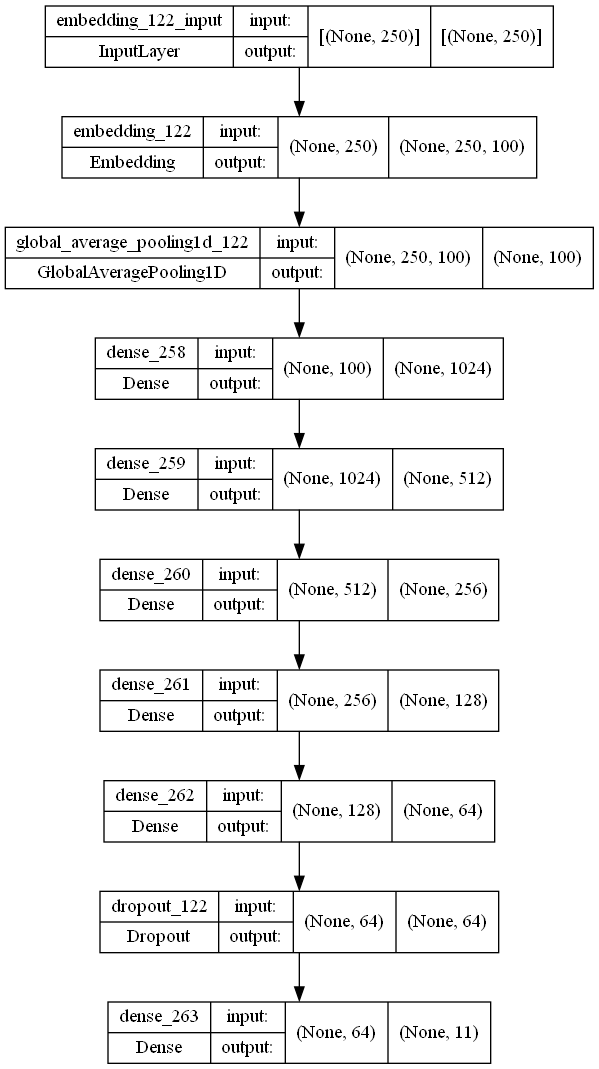

In [43]:
model = Sequential()
#model.add(Dense(25, input_dim=2, activation='relu'))
#model.add(Dense(11, activation='softmax'))
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(GlobalAveragePooling1D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.002))
model.add(Dense(11, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
plot_model(model, to_file='images/model_plot_dense.png', show_shapes=True, show_layer_names=True)

In [44]:
epochs = 500
batch_size = 128

hist = model.fit(X_train, Y_train, epochs=epochs, 
                 batch_size=batch_size,validation_split=0.2,
                 callbacks=[EarlyStopping(monitor='val_loss', 
                                          patience=3, min_delta=0.0001)])

Epoch 1/500
23/23 [==============================] - 8s 228ms/step - loss: 1.7177 - accuracy: 0.6172 - val_loss: 1.3750 - val_accuracy: 0.6347
Epoch 2/500
23/23 [==============================] - 5s 194ms/step - loss: 1.2471 - accuracy: 0.6459 - val_loss: 1.2677 - val_accuracy: 0.6347
Epoch 3/500
23/23 [==============================] - 4s 189ms/step - loss: 1.1628 - accuracy: 0.6459 - val_loss: 1.1938 - val_accuracy: 0.6347
Epoch 4/500
23/23 [==============================] - 4s 195ms/step - loss: 1.1142 - accuracy: 0.6459 - val_loss: 1.1427 - val_accuracy: 0.6347
Epoch 5/500
23/23 [==============================] - 3s 115ms/step - loss: 1.0475 - accuracy: 0.6743 - val_loss: 1.0982 - val_accuracy: 0.6676
Epoch 6/500
23/23 [==============================] - 4s 171ms/step - loss: 0.9502 - accuracy: 0.7119 - val_loss: 1.0345 - val_accuracy: 0.6881
Epoch 7/500
23/23 [==============================] - 4s 178ms/step - loss: 0.8546 - accuracy: 0.7366 - val_loss: 1.0040 - val_accuracy: 0.6881

In [45]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

49/49 [==============================] - 1s 19ms/step - loss: 0.9451 - accuracy: 0.7275
Test set
  Loss: 0.945
  Accuracy: 0.728


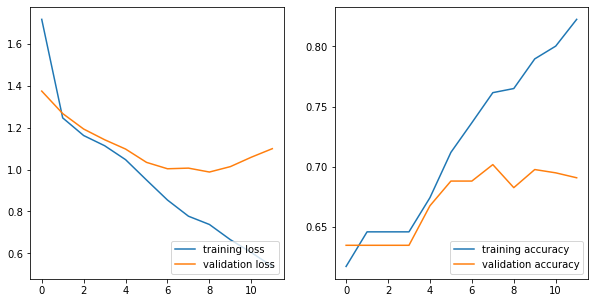

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])
axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.savefig('images/accuracy_measure_dense.png', dpi = 1200)
#plt.savefig('accuracy_measure_dense.pdf', dpi = 900)
plt.show()

In [47]:
print("Validation_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(Y_test))[1]*100))
print("Training_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_train), np.array(Y_train))[1]*100))

49/49 [==============================] - 1s 19ms/step - loss: 0.9451 - accuracy: 0.7275
Validation_Accuracy: 72.75%
115/115 [==============================] - 2s 20ms/step - loss: 0.6055 - accuracy: 0.8158
Training_Accuracy: 81.58%


In [48]:
# fit model on dataset
def fit_model(X_train, Y_train):
	# define model
	model = Sequential()
	model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
	model.add(GlobalAveragePooling1D())
	model.add(Dense(128, activation='relu'))
	model.add(Dropout(0.002))
	model.add(Dense(11, activation='sigmoid'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(X_train, Y_train, epochs=epochs, 
                 batch_size=batch_size,validation_split=0.2,
                 callbacks=[EarlyStopping(monitor='val_loss', 
                                          patience=3, min_delta=0.0001)])   
	return model

# fit and save models
n_members = 100
for i in range(n_members):
	# fit model
	model = fit_model(X_test, Y_test)
	# save model
	filename = 'models/model_' + str(i + 1) + '.h5'
	model.save(filename)
	print('>Saved %s' % filename)

Epoch 1/500
10/10 [==============================] - 4s 218ms/step - loss: 2.3635 - accuracy: 0.4501 - val_loss: 2.2875 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 160ms/step - loss: 2.2282 - accuracy: 0.6265 - val_loss: 2.0851 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 162ms/step - loss: 1.9920 - accuracy: 0.6265 - val_loss: 1.7405 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 160ms/step - loss: 1.6408 - accuracy: 0.6265 - val_loss: 1.3250 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 1s 111ms/step - loss: 1.3685 - accuracy: 0.6265 - val_loss: 1.1438 - val_accuracy: 0.7038
Epoch 6/500
10/10 [==============================] - 1s 95ms/step - loss: 1.3043 - accuracy: 0.6265 - val_loss: 1.1199 - val_accuracy: 0.7038
Epoch 7/500
10/10 [==============================] - 1s 113ms/step - loss: 1.2627 - accuracy: 0.6265 - val_loss: 1.1168 - val_accuracy: 0.7038


Epoch 14/500
10/10 [==============================] - 2s 158ms/step - loss: 1.0840 - accuracy: 0.6728 - val_loss: 0.9842 - val_accuracy: 0.7389
Epoch 15/500
10/10 [==============================] - 2s 172ms/step - loss: 1.0667 - accuracy: 0.6808 - val_loss: 0.9746 - val_accuracy: 0.7420
Epoch 16/500
10/10 [==============================] - 2s 161ms/step - loss: 1.0505 - accuracy: 0.6840 - val_loss: 0.9630 - val_accuracy: 0.7420
Epoch 17/500
10/10 [==============================] - 2s 167ms/step - loss: 1.0353 - accuracy: 0.6919 - val_loss: 0.9585 - val_accuracy: 0.7643
Epoch 18/500
10/10 [==============================] - 2s 161ms/step - loss: 1.0176 - accuracy: 0.6927 - val_loss: 0.9465 - val_accuracy: 0.7643
Epoch 19/500
10/10 [==============================] - 2s 159ms/step - loss: 1.0019 - accuracy: 0.6991 - val_loss: 0.9389 - val_accuracy: 0.7675
Epoch 20/500
10/10 [==============================] - 2s 156ms/step - loss: 0.9852 - accuracy: 0.7063 - val_loss: 0.9313 - val_accuracy:

Epoch 25/500
10/10 [==============================] - 2s 166ms/step - loss: 0.8969 - accuracy: 0.7406 - val_loss: 0.8861 - val_accuracy: 0.7643
Epoch 26/500
10/10 [==============================] - 2s 160ms/step - loss: 0.8777 - accuracy: 0.7422 - val_loss: 0.8793 - val_accuracy: 0.7611
Epoch 27/500
10/10 [==============================] - 2s 166ms/step - loss: 0.8591 - accuracy: 0.7494 - val_loss: 0.8727 - val_accuracy: 0.7580
Epoch 28/500
10/10 [==============================] - 2s 164ms/step - loss: 0.8408 - accuracy: 0.7566 - val_loss: 0.8681 - val_accuracy: 0.7516
Epoch 29/500
10/10 [==============================] - 2s 159ms/step - loss: 0.8208 - accuracy: 0.7598 - val_loss: 0.8588 - val_accuracy: 0.7643
Epoch 30/500
10/10 [==============================] - 2s 153ms/step - loss: 0.8015 - accuracy: 0.7630 - val_loss: 0.8558 - val_accuracy: 0.7580
Epoch 31/500
10/10 [==============================] - 2s 161ms/step - loss: 0.7848 - accuracy: 0.7630 - val_loss: 0.8489 - val_accuracy:

Epoch 43/500
10/10 [==============================] - 2s 158ms/step - loss: 0.6004 - accuracy: 0.8132 - val_loss: 0.8426 - val_accuracy: 0.7484
>Saved models/model_4.h5
Epoch 1/500
10/10 [==============================] - 3s 116ms/step - loss: 2.3505 - accuracy: 0.5275 - val_loss: 2.2681 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 1s 116ms/step - loss: 2.2004 - accuracy: 0.6265 - val_loss: 2.0506 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 1s 134ms/step - loss: 1.9443 - accuracy: 0.6265 - val_loss: 1.6906 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 158ms/step - loss: 1.5877 - accuracy: 0.6265 - val_loss: 1.2943 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 2s 164ms/step - loss: 1.3457 - accuracy: 0.6265 - val_loss: 1.1473 - val_accuracy: 0.7038
Epoch 6/500
10/10 [==============================] - 2s 161ms/step - loss: 1.2979 - accuracy: 0.6265 - val_loss: 1.1

Epoch 12/500
10/10 [==============================] - 2s 154ms/step - loss: 1.1418 - accuracy: 0.6265 - val_loss: 1.0254 - val_accuracy: 0.7038
Epoch 13/500
10/10 [==============================] - 2s 156ms/step - loss: 1.1218 - accuracy: 0.6265 - val_loss: 1.0131 - val_accuracy: 0.7038
Epoch 14/500
10/10 [==============================] - 1s 150ms/step - loss: 1.1031 - accuracy: 0.6265 - val_loss: 1.0013 - val_accuracy: 0.7134
Epoch 15/500
10/10 [==============================] - 2s 154ms/step - loss: 1.0850 - accuracy: 0.6417 - val_loss: 0.9890 - val_accuracy: 0.7197
Epoch 16/500
10/10 [==============================] - 2s 156ms/step - loss: 1.0672 - accuracy: 0.6552 - val_loss: 0.9758 - val_accuracy: 0.7325
Epoch 17/500
10/10 [==============================] - 2s 160ms/step - loss: 1.0484 - accuracy: 0.6704 - val_loss: 0.9694 - val_accuracy: 0.7357
Epoch 18/500
10/10 [==============================] - 2s 161ms/step - loss: 1.0333 - accuracy: 0.6864 - val_loss: 0.9613 - val_accuracy:

Epoch 28/500
10/10 [==============================] - 1s 142ms/step - loss: 0.8433 - accuracy: 0.7486 - val_loss: 0.8670 - val_accuracy: 0.7611
Epoch 29/500
10/10 [==============================] - 2s 150ms/step - loss: 0.8258 - accuracy: 0.7558 - val_loss: 0.8631 - val_accuracy: 0.7580
Epoch 30/500
10/10 [==============================] - 1s 148ms/step - loss: 0.8080 - accuracy: 0.7622 - val_loss: 0.8584 - val_accuracy: 0.7580
Epoch 31/500
10/10 [==============================] - 2s 153ms/step - loss: 0.7897 - accuracy: 0.7654 - val_loss: 0.8512 - val_accuracy: 0.7643
Epoch 32/500
10/10 [==============================] - 1s 148ms/step - loss: 0.7722 - accuracy: 0.7670 - val_loss: 0.8499 - val_accuracy: 0.7580
Epoch 33/500
10/10 [==============================] - 2s 154ms/step - loss: 0.7560 - accuracy: 0.7702 - val_loss: 0.8456 - val_accuracy: 0.7548
Epoch 34/500
10/10 [==============================] - 2s 154ms/step - loss: 0.7385 - accuracy: 0.7757 - val_loss: 0.8399 - val_accuracy:

10/10 [==============================] - 2s 153ms/step - loss: 1.8417 - accuracy: 0.6265 - val_loss: 1.5564 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 152ms/step - loss: 1.4749 - accuracy: 0.6265 - val_loss: 1.2021 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 1s 114ms/step - loss: 1.3171 - accuracy: 0.6265 - val_loss: 1.1338 - val_accuracy: 0.7038
Epoch 6/500
10/10 [==============================] - 1s 98ms/step - loss: 1.2864 - accuracy: 0.6265 - val_loss: 1.1228 - val_accuracy: 0.7038
Epoch 7/500
10/10 [==============================] - 1s 98ms/step - loss: 1.2498 - accuracy: 0.6265 - val_loss: 1.1110 - val_accuracy: 0.7038
Epoch 8/500
10/10 [==============================] - 1s 92ms/step - loss: 1.2213 - accuracy: 0.6265 - val_loss: 1.0866 - val_accuracy: 0.7038
Epoch 9/500
10/10 [==============================] - 1s 120ms/step - loss: 1.2020 - accuracy: 0.6265 - val_loss: 1.0693 - val_accuracy: 0.7038
Epoch 10/500
1

Epoch 16/500
10/10 [==============================] - 2s 150ms/step - loss: 1.0577 - accuracy: 0.6808 - val_loss: 0.9701 - val_accuracy: 0.7389
Epoch 17/500
10/10 [==============================] - 2s 159ms/step - loss: 1.0395 - accuracy: 0.6832 - val_loss: 0.9586 - val_accuracy: 0.7389
Epoch 18/500
10/10 [==============================] - 2s 157ms/step - loss: 1.0242 - accuracy: 0.6935 - val_loss: 0.9534 - val_accuracy: 0.7611
Epoch 19/500
10/10 [==============================] - 2s 157ms/step - loss: 1.0060 - accuracy: 0.6975 - val_loss: 0.9398 - val_accuracy: 0.7643
Epoch 20/500
10/10 [==============================] - 2s 156ms/step - loss: 0.9879 - accuracy: 0.7055 - val_loss: 0.9325 - val_accuracy: 0.7675
Epoch 21/500
10/10 [==============================] - 2s 162ms/step - loss: 0.9701 - accuracy: 0.7103 - val_loss: 0.9220 - val_accuracy: 0.7643
Epoch 22/500
10/10 [==============================] - 2s 166ms/step - loss: 0.9524 - accuracy: 0.7175 - val_loss: 0.9134 - val_accuracy:

Epoch 31/500
10/10 [==============================] - 2s 158ms/step - loss: 0.7915 - accuracy: 0.7694 - val_loss: 0.8549 - val_accuracy: 0.7739
Epoch 32/500
10/10 [==============================] - 2s 153ms/step - loss: 0.7748 - accuracy: 0.7709 - val_loss: 0.8545 - val_accuracy: 0.7580
Epoch 33/500
10/10 [==============================] - 1s 102ms/step - loss: 0.7582 - accuracy: 0.7757 - val_loss: 0.8461 - val_accuracy: 0.7803
Epoch 34/500
10/10 [==============================] - 1s 94ms/step - loss: 0.7421 - accuracy: 0.7757 - val_loss: 0.8458 - val_accuracy: 0.7611
Epoch 35/500
10/10 [==============================] - 1s 154ms/step - loss: 0.7229 - accuracy: 0.7805 - val_loss: 0.8464 - val_accuracy: 0.7484
Epoch 36/500
10/10 [==============================] - 1s 135ms/step - loss: 0.7052 - accuracy: 0.7805 - val_loss: 0.8399 - val_accuracy: 0.7739
Epoch 37/500
10/10 [==============================] - 2s 156ms/step - loss: 0.6872 - accuracy: 0.7861 - val_loss: 0.8396 - val_accuracy: 

Epoch 46/500
10/10 [==============================] - 2s 154ms/step - loss: 0.5434 - accuracy: 0.8308 - val_loss: 0.8461 - val_accuracy: 0.7771
>Saved models/model_12.h5
Epoch 1/500
10/10 [==============================] - 3s 208ms/step - loss: 2.3548 - accuracy: 0.4852 - val_loss: 2.2715 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 160ms/step - loss: 2.2133 - accuracy: 0.6265 - val_loss: 2.0630 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 161ms/step - loss: 1.9744 - accuracy: 0.6265 - val_loss: 1.7219 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 164ms/step - loss: 1.6419 - accuracy: 0.6265 - val_loss: 1.3184 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 2s 164ms/step - loss: 1.3828 - accuracy: 0.6265 - val_loss: 1.1405 - val_accuracy: 0.7038
Epoch 6/500
10/10 [==============================] - 2s 164ms/step - loss: 1.3042 - accuracy: 0.6265 - val_loss: 1.

Epoch 17/500
10/10 [==============================] - 2s 157ms/step - loss: 1.0294 - accuracy: 0.6856 - val_loss: 0.9544 - val_accuracy: 0.7389
Epoch 18/500
10/10 [==============================] - 2s 162ms/step - loss: 1.0126 - accuracy: 0.6903 - val_loss: 0.9472 - val_accuracy: 0.7516
Epoch 19/500
10/10 [==============================] - 2s 154ms/step - loss: 0.9980 - accuracy: 0.7087 - val_loss: 0.9416 - val_accuracy: 0.7643
Epoch 20/500
10/10 [==============================] - 2s 155ms/step - loss: 0.9817 - accuracy: 0.7023 - val_loss: 0.9270 - val_accuracy: 0.7548
Epoch 21/500
10/10 [==============================] - 2s 152ms/step - loss: 0.9630 - accuracy: 0.7167 - val_loss: 0.9291 - val_accuracy: 0.7548
Epoch 22/500
10/10 [==============================] - 2s 157ms/step - loss: 0.9457 - accuracy: 0.7231 - val_loss: 0.9096 - val_accuracy: 0.7580
Epoch 23/500
10/10 [==============================] - 2s 163ms/step - loss: 0.9285 - accuracy: 0.7255 - val_loss: 0.9088 - val_accuracy:

Epoch 34/500
10/10 [==============================] - 2s 163ms/step - loss: 0.7352 - accuracy: 0.7757 - val_loss: 0.8358 - val_accuracy: 0.7675
Epoch 35/500
10/10 [==============================] - 2s 167ms/step - loss: 0.7170 - accuracy: 0.7789 - val_loss: 0.8359 - val_accuracy: 0.7611
Epoch 36/500
10/10 [==============================] - 2s 166ms/step - loss: 0.6974 - accuracy: 0.7797 - val_loss: 0.8308 - val_accuracy: 0.7771
Epoch 37/500
10/10 [==============================] - 2s 162ms/step - loss: 0.6805 - accuracy: 0.7869 - val_loss: 0.8435 - val_accuracy: 0.7420
Epoch 38/500
10/10 [==============================] - 2s 163ms/step - loss: 0.6613 - accuracy: 0.7965 - val_loss: 0.8317 - val_accuracy: 0.7803
Epoch 39/500
10/10 [==============================] - 2s 162ms/step - loss: 0.6390 - accuracy: 0.8037 - val_loss: 0.8314 - val_accuracy: 0.7452
>Saved models/model_15.h5
Epoch 1/500
10/10 [==============================] - 4s 217ms/step - loss: 2.3478 - accuracy: 0.5634 - val_los

10/10 [==============================] - 2s 156ms/step - loss: 1.1202 - accuracy: 0.6265 - val_loss: 1.0085 - val_accuracy: 0.7197
Epoch 13/500
10/10 [==============================] - 2s 153ms/step - loss: 1.0998 - accuracy: 0.6457 - val_loss: 0.9971 - val_accuracy: 0.7293
Epoch 14/500
10/10 [==============================] - 2s 158ms/step - loss: 1.0810 - accuracy: 0.6616 - val_loss: 0.9813 - val_accuracy: 0.7325
Epoch 15/500
10/10 [==============================] - 2s 157ms/step - loss: 1.0642 - accuracy: 0.6752 - val_loss: 0.9765 - val_accuracy: 0.7389
Epoch 16/500
10/10 [==============================] - 1s 109ms/step - loss: 1.0452 - accuracy: 0.6832 - val_loss: 0.9615 - val_accuracy: 0.7389
Epoch 17/500
10/10 [==============================] - 1s 96ms/step - loss: 1.0283 - accuracy: 0.6872 - val_loss: 0.9568 - val_accuracy: 0.7580
Epoch 18/500
10/10 [==============================] - 1s 114ms/step - loss: 1.0096 - accuracy: 0.6967 - val_loss: 0.9431 - val_accuracy: 0.7516
Epoch 

Epoch 27/500
10/10 [==============================] - 2s 162ms/step - loss: 0.8551 - accuracy: 0.7542 - val_loss: 0.8729 - val_accuracy: 0.7580
Epoch 28/500
10/10 [==============================] - 2s 161ms/step - loss: 0.8370 - accuracy: 0.7606 - val_loss: 0.8632 - val_accuracy: 0.7707
Epoch 29/500
10/10 [==============================] - 2s 162ms/step - loss: 0.8187 - accuracy: 0.7582 - val_loss: 0.8613 - val_accuracy: 0.7580
Epoch 30/500
10/10 [==============================] - 2s 159ms/step - loss: 0.8010 - accuracy: 0.7646 - val_loss: 0.8518 - val_accuracy: 0.7739
Epoch 31/500
10/10 [==============================] - 2s 165ms/step - loss: 0.7830 - accuracy: 0.7678 - val_loss: 0.8536 - val_accuracy: 0.7580
Epoch 32/500
10/10 [==============================] - 2s 153ms/step - loss: 0.7649 - accuracy: 0.7725 - val_loss: 0.8455 - val_accuracy: 0.7643
Epoch 33/500
10/10 [==============================] - 2s 151ms/step - loss: 0.7460 - accuracy: 0.7773 - val_loss: 0.8425 - val_accuracy:

Epoch 41/500
10/10 [==============================] - 2s 158ms/step - loss: 0.6211 - accuracy: 0.8061 - val_loss: 0.8326 - val_accuracy: 0.7611
Epoch 42/500
10/10 [==============================] - 2s 151ms/step - loss: 0.6027 - accuracy: 0.8140 - val_loss: 0.8345 - val_accuracy: 0.7643
>Saved models/model_19.h5
Epoch 1/500
10/10 [==============================] - 3s 202ms/step - loss: 2.3427 - accuracy: 0.5251 - val_loss: 2.2466 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 156ms/step - loss: 2.1765 - accuracy: 0.6265 - val_loss: 1.9984 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 159ms/step - loss: 1.8950 - accuracy: 0.6265 - val_loss: 1.6087 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 156ms/step - loss: 1.5360 - accuracy: 0.6265 - val_loss: 1.2354 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 2s 171ms/step - loss: 1.3391 - accuracy: 0.6265 - val_loss: 1

Epoch 11/500
10/10 [==============================] - 2s 155ms/step - loss: 1.1608 - accuracy: 0.6265 - val_loss: 1.0378 - val_accuracy: 0.7038
Epoch 12/500
10/10 [==============================] - 2s 160ms/step - loss: 1.1376 - accuracy: 0.6265 - val_loss: 1.0176 - val_accuracy: 0.7038
Epoch 13/500
10/10 [==============================] - 2s 166ms/step - loss: 1.1179 - accuracy: 0.6273 - val_loss: 1.0018 - val_accuracy: 0.7102
Epoch 14/500
10/10 [==============================] - 2s 156ms/step - loss: 1.0973 - accuracy: 0.6385 - val_loss: 0.9923 - val_accuracy: 0.7229
Epoch 15/500
10/10 [==============================] - 1s 101ms/step - loss: 1.0793 - accuracy: 0.6648 - val_loss: 0.9826 - val_accuracy: 0.7357
Epoch 16/500
10/10 [==============================] - 1s 93ms/step - loss: 1.0608 - accuracy: 0.6720 - val_loss: 0.9675 - val_accuracy: 0.7357
Epoch 17/500
10/10 [==============================] - 1s 113ms/step - loss: 1.0428 - accuracy: 0.6784 - val_loss: 0.9591 - val_accuracy: 

Epoch 25/500
10/10 [==============================] - 2s 158ms/step - loss: 0.8935 - accuracy: 0.7382 - val_loss: 0.8868 - val_accuracy: 0.7675
Epoch 26/500
10/10 [==============================] - 2s 158ms/step - loss: 0.8776 - accuracy: 0.7470 - val_loss: 0.8829 - val_accuracy: 0.7611
Epoch 27/500
10/10 [==============================] - 2s 162ms/step - loss: 0.8606 - accuracy: 0.7502 - val_loss: 0.8735 - val_accuracy: 0.7643
Epoch 28/500
10/10 [==============================] - 2s 162ms/step - loss: 0.8435 - accuracy: 0.7526 - val_loss: 0.8683 - val_accuracy: 0.7675
Epoch 29/500
10/10 [==============================] - 2s 165ms/step - loss: 0.8284 - accuracy: 0.7566 - val_loss: 0.8669 - val_accuracy: 0.7580
Epoch 30/500
10/10 [==============================] - 2s 164ms/step - loss: 0.8151 - accuracy: 0.7614 - val_loss: 0.8567 - val_accuracy: 0.7739
Epoch 31/500
10/10 [==============================] - 2s 155ms/step - loss: 0.7946 - accuracy: 0.7702 - val_loss: 0.8543 - val_accuracy:

Epoch 42/500
10/10 [==============================] - 2s 169ms/step - loss: 0.6410 - accuracy: 0.7981 - val_loss: 0.8289 - val_accuracy: 0.7452
Epoch 43/500
10/10 [==============================] - 2s 170ms/step - loss: 0.6227 - accuracy: 0.8045 - val_loss: 0.8289 - val_accuracy: 0.7771
Epoch 44/500
10/10 [==============================] - 2s 155ms/step - loss: 0.6036 - accuracy: 0.8077 - val_loss: 0.8305 - val_accuracy: 0.7548
>Saved models/model_23.h5
Epoch 1/500
10/10 [==============================] - 3s 191ms/step - loss: 2.3591 - accuracy: 0.4517 - val_loss: 2.2699 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 160ms/step - loss: 2.1991 - accuracy: 0.6265 - val_loss: 2.0448 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 156ms/step - loss: 1.9363 - accuracy: 0.6265 - val_loss: 1.6766 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 155ms/step - loss: 1.5760 - accuracy: 0.6265 - val_loss: 

Epoch 15/500
10/10 [==============================] - 2s 160ms/step - loss: 1.0440 - accuracy: 0.6848 - val_loss: 0.9592 - val_accuracy: 0.7452
Epoch 16/500
10/10 [==============================] - 2s 158ms/step - loss: 1.0278 - accuracy: 0.6895 - val_loss: 0.9532 - val_accuracy: 0.7643
Epoch 17/500
10/10 [==============================] - 2s 161ms/step - loss: 1.0104 - accuracy: 0.7007 - val_loss: 0.9443 - val_accuracy: 0.7675
Epoch 18/500
10/10 [==============================] - 2s 164ms/step - loss: 0.9937 - accuracy: 0.7079 - val_loss: 0.9359 - val_accuracy: 0.7675
Epoch 19/500
10/10 [==============================] - 2s 161ms/step - loss: 0.9766 - accuracy: 0.7135 - val_loss: 0.9234 - val_accuracy: 0.7675
Epoch 20/500
10/10 [==============================] - 2s 161ms/step - loss: 0.9591 - accuracy: 0.7215 - val_loss: 0.9170 - val_accuracy: 0.7675
Epoch 21/500
10/10 [==============================] - 2s 159ms/step - loss: 0.9427 - accuracy: 0.7263 - val_loss: 0.9100 - val_accuracy:

Epoch 29/500
10/10 [==============================] - 2s 160ms/step - loss: 0.8212 - accuracy: 0.7566 - val_loss: 0.8583 - val_accuracy: 0.7611
Epoch 30/500
10/10 [==============================] - 2s 160ms/step - loss: 0.8026 - accuracy: 0.7686 - val_loss: 0.8498 - val_accuracy: 0.7739
Epoch 31/500
10/10 [==============================] - 2s 165ms/step - loss: 0.7856 - accuracy: 0.7678 - val_loss: 0.8485 - val_accuracy: 0.7580
Epoch 32/500
10/10 [==============================] - 2s 161ms/step - loss: 0.7669 - accuracy: 0.7694 - val_loss: 0.8407 - val_accuracy: 0.7771
Epoch 33/500
10/10 [==============================] - 2s 156ms/step - loss: 0.7488 - accuracy: 0.7709 - val_loss: 0.8397 - val_accuracy: 0.7675
Epoch 34/500
10/10 [==============================] - 2s 157ms/step - loss: 0.7294 - accuracy: 0.7741 - val_loss: 0.8346 - val_accuracy: 0.7771
Epoch 35/500
10/10 [==============================] - 2s 157ms/step - loss: 0.7113 - accuracy: 0.7797 - val_loss: 0.8332 - val_accuracy:

10/10 [==============================] - 4s 231ms/step - loss: 2.3382 - accuracy: 0.5674 - val_loss: 2.2381 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 168ms/step - loss: 2.1610 - accuracy: 0.6265 - val_loss: 1.9697 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 164ms/step - loss: 1.8607 - accuracy: 0.6265 - val_loss: 1.5514 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 160ms/step - loss: 1.4934 - accuracy: 0.6265 - val_loss: 1.2024 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 2s 159ms/step - loss: 1.3397 - accuracy: 0.6265 - val_loss: 1.1301 - val_accuracy: 0.7038
Epoch 6/500
10/10 [==============================] - 2s 156ms/step - loss: 1.2894 - accuracy: 0.6265 - val_loss: 1.1219 - val_accuracy: 0.7038
Epoch 7/500
10/10 [==============================] - 2s 160ms/step - loss: 1.2526 - accuracy: 0.6265 - val_loss: 1.1106 - val_accuracy: 0.7038
Epoch 8/500

Epoch 17/500
10/10 [==============================] - 2s 151ms/step - loss: 1.0531 - accuracy: 0.6752 - val_loss: 0.9672 - val_accuracy: 0.7389
Epoch 18/500
10/10 [==============================] - 2s 158ms/step - loss: 1.0352 - accuracy: 0.6800 - val_loss: 0.9601 - val_accuracy: 0.7389
Epoch 19/500
10/10 [==============================] - 2s 163ms/step - loss: 1.0176 - accuracy: 0.6887 - val_loss: 0.9510 - val_accuracy: 0.7548
Epoch 20/500
10/10 [==============================] - 1s 102ms/step - loss: 1.0017 - accuracy: 0.6951 - val_loss: 0.9398 - val_accuracy: 0.7580
Epoch 21/500
10/10 [==============================] - 1s 96ms/step - loss: 0.9826 - accuracy: 0.7031 - val_loss: 0.9338 - val_accuracy: 0.7643
Epoch 22/500
10/10 [==============================] - 2s 158ms/step - loss: 0.9656 - accuracy: 0.7119 - val_loss: 0.9211 - val_accuracy: 0.7643
Epoch 23/500
10/10 [==============================] - 1s 134ms/step - loss: 0.9490 - accuracy: 0.7103 - val_loss: 0.9116 - val_accuracy: 

Epoch 29/500
10/10 [==============================] - 2s 156ms/step - loss: 0.8731 - accuracy: 0.7462 - val_loss: 0.8783 - val_accuracy: 0.7516
Epoch 30/500
10/10 [==============================] - 2s 171ms/step - loss: 0.8535 - accuracy: 0.7446 - val_loss: 0.8697 - val_accuracy: 0.7611
Epoch 31/500
10/10 [==============================] - 2s 170ms/step - loss: 0.8333 - accuracy: 0.7590 - val_loss: 0.8654 - val_accuracy: 0.7548
Epoch 32/500
10/10 [==============================] - 2s 187ms/step - loss: 0.8166 - accuracy: 0.7606 - val_loss: 0.8582 - val_accuracy: 0.7548
Epoch 33/500
10/10 [==============================] - 2s 187ms/step - loss: 0.7996 - accuracy: 0.7662 - val_loss: 0.8532 - val_accuracy: 0.7580
Epoch 34/500
10/10 [==============================] - 2s 157ms/step - loss: 0.7832 - accuracy: 0.7638 - val_loss: 0.8491 - val_accuracy: 0.7580
Epoch 35/500
10/10 [==============================] - 2s 165ms/step - loss: 0.7639 - accuracy: 0.7733 - val_loss: 0.8441 - val_accuracy:

Epoch 42/500
10/10 [==============================] - 2s 155ms/step - loss: 0.6102 - accuracy: 0.8148 - val_loss: 0.8296 - val_accuracy: 0.7643
Epoch 43/500
10/10 [==============================] - 2s 157ms/step - loss: 0.5893 - accuracy: 0.8196 - val_loss: 0.8299 - val_accuracy: 0.7580
>Saved models/model_31.h5
Epoch 1/500
10/10 [==============================] - 4s 208ms/step - loss: 2.3295 - accuracy: 0.5714 - val_loss: 2.2255 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 153ms/step - loss: 2.1476 - accuracy: 0.6265 - val_loss: 1.9508 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 160ms/step - loss: 1.8367 - accuracy: 0.6265 - val_loss: 1.5364 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 157ms/step - loss: 1.4817 - accuracy: 0.6265 - val_loss: 1.2005 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 2s 158ms/step - loss: 1.3305 - accuracy: 0.6265 - val_loss: 1

10/10 [==============================] - 1s 95ms/step - loss: 1.1601 - accuracy: 0.6265 - val_loss: 1.0343 - val_accuracy: 0.7038
Epoch 12/500
10/10 [==============================] - 1s 137ms/step - loss: 1.1400 - accuracy: 0.6265 - val_loss: 1.0230 - val_accuracy: 0.7038
Epoch 13/500
10/10 [==============================] - 1s 123ms/step - loss: 1.1232 - accuracy: 0.6265 - val_loss: 1.0107 - val_accuracy: 0.7038
Epoch 14/500
10/10 [==============================] - 2s 158ms/step - loss: 1.1067 - accuracy: 0.6265 - val_loss: 0.9976 - val_accuracy: 0.7102
Epoch 15/500
10/10 [==============================] - 2s 156ms/step - loss: 1.0889 - accuracy: 0.6393 - val_loss: 0.9907 - val_accuracy: 0.7229
Epoch 16/500
10/10 [==============================] - 2s 157ms/step - loss: 1.0715 - accuracy: 0.6592 - val_loss: 0.9775 - val_accuracy: 0.7325
Epoch 17/500
10/10 [==============================] - 2s 160ms/step - loss: 1.0545 - accuracy: 0.6728 - val_loss: 0.9672 - val_accuracy: 0.7389
Epoch 

Epoch 25/500
10/10 [==============================] - 2s 162ms/step - loss: 0.9097 - accuracy: 0.7350 - val_loss: 0.8927 - val_accuracy: 0.7643
Epoch 26/500
10/10 [==============================] - 2s 160ms/step - loss: 0.8937 - accuracy: 0.7390 - val_loss: 0.8850 - val_accuracy: 0.7675
Epoch 27/500
10/10 [==============================] - 2s 156ms/step - loss: 0.8776 - accuracy: 0.7430 - val_loss: 0.8776 - val_accuracy: 0.7643
Epoch 28/500
10/10 [==============================] - 2s 160ms/step - loss: 0.8613 - accuracy: 0.7438 - val_loss: 0.8741 - val_accuracy: 0.7611
Epoch 29/500
10/10 [==============================] - 2s 160ms/step - loss: 0.8445 - accuracy: 0.7542 - val_loss: 0.8658 - val_accuracy: 0.7643
Epoch 30/500
10/10 [==============================] - 2s 158ms/step - loss: 0.8293 - accuracy: 0.7518 - val_loss: 0.8615 - val_accuracy: 0.7580
Epoch 31/500
10/10 [==============================] - 2s 161ms/step - loss: 0.8112 - accuracy: 0.7614 - val_loss: 0.8538 - val_accuracy:

Epoch 36/500
10/10 [==============================] - 2s 155ms/step - loss: 0.7014 - accuracy: 0.7805 - val_loss: 0.8381 - val_accuracy: 0.7516
Epoch 37/500
10/10 [==============================] - 2s 157ms/step - loss: 0.6817 - accuracy: 0.7869 - val_loss: 0.8376 - val_accuracy: 0.7516
Epoch 38/500
10/10 [==============================] - 2s 156ms/step - loss: 0.6643 - accuracy: 0.7973 - val_loss: 0.8370 - val_accuracy: 0.7803
Epoch 39/500
10/10 [==============================] - 2s 157ms/step - loss: 0.6477 - accuracy: 0.7973 - val_loss: 0.8345 - val_accuracy: 0.7739
Epoch 40/500
10/10 [==============================] - 2s 158ms/step - loss: 0.6261 - accuracy: 0.8085 - val_loss: 0.8372 - val_accuracy: 0.7484
Epoch 41/500
10/10 [==============================] - 2s 157ms/step - loss: 0.6102 - accuracy: 0.8117 - val_loss: 0.8365 - val_accuracy: 0.7771
Epoch 42/500
10/10 [==============================] - 2s 155ms/step - loss: 0.5890 - accuracy: 0.8268 - val_loss: 0.8379 - val_accuracy:

Epoch 11/500
10/10 [==============================] - 1s 100ms/step - loss: 1.1531 - accuracy: 0.6265 - val_loss: 1.0317 - val_accuracy: 0.7038
Epoch 12/500
10/10 [==============================] - 1s 148ms/step - loss: 1.1290 - accuracy: 0.6281 - val_loss: 1.0130 - val_accuracy: 0.7102
Epoch 13/500
10/10 [==============================] - 1s 116ms/step - loss: 1.1072 - accuracy: 0.6401 - val_loss: 0.9976 - val_accuracy: 0.7229
Epoch 14/500
10/10 [==============================] - 2s 166ms/step - loss: 1.0884 - accuracy: 0.6640 - val_loss: 0.9882 - val_accuracy: 0.7325
Epoch 15/500
10/10 [==============================] - 2s 157ms/step - loss: 1.0693 - accuracy: 0.6720 - val_loss: 0.9748 - val_accuracy: 0.7389
Epoch 16/500
10/10 [==============================] - 2s 161ms/step - loss: 1.0522 - accuracy: 0.6840 - val_loss: 0.9690 - val_accuracy: 0.7516
Epoch 17/500
10/10 [==============================] - 2s 162ms/step - loss: 1.0352 - accuracy: 0.6872 - val_loss: 0.9567 - val_accuracy:

Epoch 26/500
10/10 [==============================] - 2s 160ms/step - loss: 0.8879 - accuracy: 0.7382 - val_loss: 0.8863 - val_accuracy: 0.7611
Epoch 27/500
10/10 [==============================] - 2s 157ms/step - loss: 0.8729 - accuracy: 0.7510 - val_loss: 0.8793 - val_accuracy: 0.7580
Epoch 28/500
10/10 [==============================] - 2s 153ms/step - loss: 0.8561 - accuracy: 0.7462 - val_loss: 0.8710 - val_accuracy: 0.7611
Epoch 29/500
10/10 [==============================] - 2s 159ms/step - loss: 0.8382 - accuracy: 0.7598 - val_loss: 0.8661 - val_accuracy: 0.7580
Epoch 30/500
10/10 [==============================] - 2s 157ms/step - loss: 0.8209 - accuracy: 0.7622 - val_loss: 0.8621 - val_accuracy: 0.7516
Epoch 31/500
10/10 [==============================] - 2s 156ms/step - loss: 0.8059 - accuracy: 0.7614 - val_loss: 0.8564 - val_accuracy: 0.7580
Epoch 32/500
10/10 [==============================] - 2s 156ms/step - loss: 0.7886 - accuracy: 0.7702 - val_loss: 0.8511 - val_accuracy:

Epoch 42/500
10/10 [==============================] - 2s 156ms/step - loss: 0.5857 - accuracy: 0.8140 - val_loss: 0.8379 - val_accuracy: 0.7484
Epoch 43/500
10/10 [==============================] - 2s 158ms/step - loss: 0.5659 - accuracy: 0.8252 - val_loss: 0.8369 - val_accuracy: 0.7611
>Saved models/model_39.h5
Epoch 1/500
10/10 [==============================] - 4s 215ms/step - loss: 2.3349 - accuracy: 0.5682 - val_loss: 2.2367 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 170ms/step - loss: 2.1559 - accuracy: 0.6265 - val_loss: 1.9686 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 162ms/step - loss: 1.8536 - accuracy: 0.6265 - val_loss: 1.5509 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 164ms/step - loss: 1.4841 - accuracy: 0.6265 - val_loss: 1.1882 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 2s 151ms/step - loss: 1.3103 - accuracy: 0.6265 - val_loss: 1

Epoch 15/500
10/10 [==============================] - 1s 96ms/step - loss: 1.0739 - accuracy: 0.6712 - val_loss: 0.9826 - val_accuracy: 0.7357
Epoch 16/500
10/10 [==============================] - 1s 96ms/step - loss: 1.0585 - accuracy: 0.6808 - val_loss: 0.9716 - val_accuracy: 0.7389
Epoch 17/500
10/10 [==============================] - 1s 93ms/step - loss: 1.0404 - accuracy: 0.6856 - val_loss: 0.9628 - val_accuracy: 0.7452
Epoch 18/500
10/10 [==============================] - 1s 93ms/step - loss: 1.0252 - accuracy: 0.6879 - val_loss: 0.9542 - val_accuracy: 0.7516
Epoch 19/500
10/10 [==============================] - 1s 94ms/step - loss: 1.0094 - accuracy: 0.7015 - val_loss: 0.9462 - val_accuracy: 0.7643
Epoch 20/500
10/10 [==============================] - 1s 94ms/step - loss: 0.9917 - accuracy: 0.7007 - val_loss: 0.9343 - val_accuracy: 0.7643
Epoch 21/500
10/10 [==============================] - 1s 93ms/step - loss: 0.9748 - accuracy: 0.7143 - val_loss: 0.9306 - val_accuracy: 0.7643

Epoch 28/500
10/10 [==============================] - 1s 108ms/step - loss: 0.8630 - accuracy: 0.7534 - val_loss: 0.8736 - val_accuracy: 0.7643
Epoch 29/500
10/10 [==============================] - 1s 139ms/step - loss: 0.8445 - accuracy: 0.7510 - val_loss: 0.8658 - val_accuracy: 0.7675
Epoch 30/500
10/10 [==============================] - 2s 162ms/step - loss: 0.8272 - accuracy: 0.7606 - val_loss: 0.8622 - val_accuracy: 0.7643
Epoch 31/500
10/10 [==============================] - 2s 154ms/step - loss: 0.8099 - accuracy: 0.7622 - val_loss: 0.8560 - val_accuracy: 0.7643
Epoch 32/500
10/10 [==============================] - 2s 154ms/step - loss: 0.7926 - accuracy: 0.7646 - val_loss: 0.8477 - val_accuracy: 0.7707
Epoch 33/500
10/10 [==============================] - 2s 154ms/step - loss: 0.7729 - accuracy: 0.7733 - val_loss: 0.8480 - val_accuracy: 0.7580
Epoch 34/500
10/10 [==============================] - 2s 158ms/step - loss: 0.7557 - accuracy: 0.7741 - val_loss: 0.8393 - val_accuracy:

Epoch 41/500
10/10 [==============================] - 2s 157ms/step - loss: 0.6218 - accuracy: 0.8061 - val_loss: 0.8364 - val_accuracy: 0.7580
Epoch 42/500
10/10 [==============================] - 2s 154ms/step - loss: 0.6057 - accuracy: 0.8172 - val_loss: 0.8365 - val_accuracy: 0.7707
>Saved models/model_43.h5
Epoch 1/500
10/10 [==============================] - 3s 204ms/step - loss: 2.3598 - accuracy: 0.4477 - val_loss: 2.2892 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 160ms/step - loss: 2.2297 - accuracy: 0.6265 - val_loss: 2.1017 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 157ms/step - loss: 2.0076 - accuracy: 0.6265 - val_loss: 1.7782 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 152ms/step - loss: 1.6609 - accuracy: 0.6265 - val_loss: 1.3634 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 2s 158ms/step - loss: 1.3505 - accuracy: 0.6265 - val_loss: 1

Epoch 11/500
10/10 [==============================] - 2s 158ms/step - loss: 1.1654 - accuracy: 0.6265 - val_loss: 1.0422 - val_accuracy: 0.7038
Epoch 12/500
10/10 [==============================] - 2s 161ms/step - loss: 1.1459 - accuracy: 0.6265 - val_loss: 1.0262 - val_accuracy: 0.7038
Epoch 13/500
10/10 [==============================] - 2s 161ms/step - loss: 1.1271 - accuracy: 0.6265 - val_loss: 1.0137 - val_accuracy: 0.7038
Epoch 14/500
10/10 [==============================] - 2s 158ms/step - loss: 1.1062 - accuracy: 0.6289 - val_loss: 1.0016 - val_accuracy: 0.7197
Epoch 15/500
10/10 [==============================] - 2s 161ms/step - loss: 1.0884 - accuracy: 0.6528 - val_loss: 0.9920 - val_accuracy: 0.7325
Epoch 16/500
10/10 [==============================] - 2s 161ms/step - loss: 1.0725 - accuracy: 0.6632 - val_loss: 0.9789 - val_accuracy: 0.7325
Epoch 17/500
10/10 [==============================] - 2s 163ms/step - loss: 1.0541 - accuracy: 0.6736 - val_loss: 0.9690 - val_accuracy:

Epoch 27/500
10/10 [==============================] - 2s 155ms/step - loss: 0.8691 - accuracy: 0.7502 - val_loss: 0.8797 - val_accuracy: 0.7611
Epoch 28/500
10/10 [==============================] - 2s 156ms/step - loss: 0.8541 - accuracy: 0.7558 - val_loss: 0.8748 - val_accuracy: 0.7611
Epoch 29/500
10/10 [==============================] - 2s 151ms/step - loss: 0.8368 - accuracy: 0.7574 - val_loss: 0.8731 - val_accuracy: 0.7548
Epoch 30/500
10/10 [==============================] - 2s 157ms/step - loss: 0.8206 - accuracy: 0.7622 - val_loss: 0.8655 - val_accuracy: 0.7580
Epoch 31/500
10/10 [==============================] - 2s 153ms/step - loss: 0.8055 - accuracy: 0.7662 - val_loss: 0.8596 - val_accuracy: 0.7675
Epoch 32/500
10/10 [==============================] - 2s 157ms/step - loss: 0.7887 - accuracy: 0.7686 - val_loss: 0.8544 - val_accuracy: 0.7707
Epoch 33/500
10/10 [==============================] - 2s 155ms/step - loss: 0.7735 - accuracy: 0.7717 - val_loss: 0.8502 - val_accuracy:

Epoch 40/500
10/10 [==============================] - 2s 157ms/step - loss: 0.6609 - accuracy: 0.7989 - val_loss: 0.8349 - val_accuracy: 0.7739
Epoch 41/500
10/10 [==============================] - 2s 158ms/step - loss: 0.6442 - accuracy: 0.7997 - val_loss: 0.8382 - val_accuracy: 0.7452
Epoch 42/500
10/10 [==============================] - 2s 152ms/step - loss: 0.6283 - accuracy: 0.8069 - val_loss: 0.8373 - val_accuracy: 0.7675
Epoch 43/500
10/10 [==============================] - 2s 158ms/step - loss: 0.6129 - accuracy: 0.8093 - val_loss: 0.8387 - val_accuracy: 0.7643
>Saved models/model_47.h5
Epoch 1/500
10/10 [==============================] - 4s 216ms/step - loss: 2.3347 - accuracy: 0.5786 - val_loss: 2.2395 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 164ms/step - loss: 2.1608 - accuracy: 0.6265 - val_loss: 1.9792 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 164ms/step - loss: 1.8629 - accuracy: 0.6265 - val_loss:

Epoch 13/500
10/10 [==============================] - 2s 153ms/step - loss: 1.0921 - accuracy: 0.6600 - val_loss: 0.9886 - val_accuracy: 0.7325
Epoch 14/500
10/10 [==============================] - 2s 157ms/step - loss: 1.0723 - accuracy: 0.6664 - val_loss: 0.9767 - val_accuracy: 0.7357
Epoch 15/500
10/10 [==============================] - 1s 103ms/step - loss: 1.0561 - accuracy: 0.6800 - val_loss: 0.9683 - val_accuracy: 0.7389
Epoch 16/500
10/10 [==============================] - 1s 93ms/step - loss: 1.0383 - accuracy: 0.6816 - val_loss: 0.9554 - val_accuracy: 0.7389
Epoch 17/500
10/10 [==============================] - 1s 153ms/step - loss: 1.0195 - accuracy: 0.6872 - val_loss: 0.9507 - val_accuracy: 0.7611
Epoch 18/500
10/10 [==============================] - 1s 126ms/step - loss: 1.0027 - accuracy: 0.6991 - val_loss: 0.9394 - val_accuracy: 0.7643
Epoch 19/500
10/10 [==============================] - 2s 158ms/step - loss: 0.9847 - accuracy: 0.7055 - val_loss: 0.9273 - val_accuracy: 

Epoch 30/500
10/10 [==============================] - 2s 166ms/step - loss: 0.8349 - accuracy: 0.7574 - val_loss: 0.8657 - val_accuracy: 0.7675
Epoch 31/500
10/10 [==============================] - 2s 159ms/step - loss: 0.8164 - accuracy: 0.7614 - val_loss: 0.8609 - val_accuracy: 0.7580
Epoch 32/500
10/10 [==============================] - 2s 158ms/step - loss: 0.7977 - accuracy: 0.7654 - val_loss: 0.8552 - val_accuracy: 0.7580
Epoch 33/500
10/10 [==============================] - 2s 157ms/step - loss: 0.7787 - accuracy: 0.7709 - val_loss: 0.8498 - val_accuracy: 0.7611
Epoch 34/500
10/10 [==============================] - 2s 160ms/step - loss: 0.7598 - accuracy: 0.7709 - val_loss: 0.8474 - val_accuracy: 0.7580
Epoch 35/500
10/10 [==============================] - 2s 155ms/step - loss: 0.7404 - accuracy: 0.7765 - val_loss: 0.8398 - val_accuracy: 0.7771
Epoch 36/500
10/10 [==============================] - 2s 158ms/step - loss: 0.7226 - accuracy: 0.7781 - val_loss: 0.8481 - val_accuracy:

Epoch 44/500
10/10 [==============================] - 2s 163ms/step - loss: 0.5697 - accuracy: 0.8268 - val_loss: 0.8277 - val_accuracy: 0.7643
>Saved models/model_51.h5
Epoch 1/500
10/10 [==============================] - 4s 207ms/step - loss: 2.3339 - accuracy: 0.5714 - val_loss: 2.2226 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 160ms/step - loss: 2.1371 - accuracy: 0.6265 - val_loss: 1.9283 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 157ms/step - loss: 1.8120 - accuracy: 0.6265 - val_loss: 1.4911 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 160ms/step - loss: 1.4593 - accuracy: 0.6265 - val_loss: 1.1897 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 2s 154ms/step - loss: 1.3345 - accuracy: 0.6265 - val_loss: 1.1364 - val_accuracy: 0.7038
Epoch 6/500
10/10 [==============================] - 1s 105ms/step - loss: 1.2821 - accuracy: 0.6265 - val_loss: 1.

Epoch 17/500
10/10 [==============================] - 2s 155ms/step - loss: 1.0310 - accuracy: 0.6895 - val_loss: 0.9510 - val_accuracy: 0.7516
Epoch 18/500
10/10 [==============================] - 2s 162ms/step - loss: 1.0149 - accuracy: 0.6967 - val_loss: 0.9482 - val_accuracy: 0.7675
Epoch 19/500
10/10 [==============================] - 2s 161ms/step - loss: 0.9994 - accuracy: 0.7055 - val_loss: 0.9339 - val_accuracy: 0.7643
Epoch 20/500
10/10 [==============================] - 2s 161ms/step - loss: 0.9823 - accuracy: 0.7103 - val_loss: 0.9305 - val_accuracy: 0.7643
Epoch 21/500
10/10 [==============================] - 2s 166ms/step - loss: 0.9659 - accuracy: 0.7207 - val_loss: 0.9177 - val_accuracy: 0.7675
Epoch 22/500
10/10 [==============================] - 2s 162ms/step - loss: 0.9500 - accuracy: 0.7231 - val_loss: 0.9120 - val_accuracy: 0.7675
Epoch 23/500
10/10 [==============================] - 2s 164ms/step - loss: 0.9338 - accuracy: 0.7263 - val_loss: 0.9037 - val_accuracy:

Epoch 31/500
10/10 [==============================] - 2s 152ms/step - loss: 0.8022 - accuracy: 0.7614 - val_loss: 0.8571 - val_accuracy: 0.7580
Epoch 32/500
10/10 [==============================] - 2s 152ms/step - loss: 0.7861 - accuracy: 0.7694 - val_loss: 0.8480 - val_accuracy: 0.7707
Epoch 33/500
10/10 [==============================] - 2s 152ms/step - loss: 0.7705 - accuracy: 0.7694 - val_loss: 0.8531 - val_accuracy: 0.7484
Epoch 34/500
10/10 [==============================] - 2s 154ms/step - loss: 0.7540 - accuracy: 0.7709 - val_loss: 0.8409 - val_accuracy: 0.7739
Epoch 35/500
10/10 [==============================] - 2s 156ms/step - loss: 0.7368 - accuracy: 0.7749 - val_loss: 0.8393 - val_accuracy: 0.7707
Epoch 36/500
10/10 [==============================] - 2s 165ms/step - loss: 0.7187 - accuracy: 0.7773 - val_loss: 0.8385 - val_accuracy: 0.7516
Epoch 37/500
10/10 [==============================] - 2s 151ms/step - loss: 0.7029 - accuracy: 0.7821 - val_loss: 0.8351 - val_accuracy:

Epoch 45/500
10/10 [==============================] - 1s 127ms/step - loss: 0.5867 - accuracy: 0.8164 - val_loss: 0.8393 - val_accuracy: 0.7771
>Saved models/model_55.h5
Epoch 1/500
10/10 [==============================] - 3s 200ms/step - loss: 2.3534 - accuracy: 0.5084 - val_loss: 2.2610 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 158ms/step - loss: 2.1976 - accuracy: 0.6265 - val_loss: 2.0324 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 159ms/step - loss: 1.9357 - accuracy: 0.6265 - val_loss: 1.6556 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 157ms/step - loss: 1.5823 - accuracy: 0.6265 - val_loss: 1.2634 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 2s 165ms/step - loss: 1.3532 - accuracy: 0.6265 - val_loss: 1.1363 - val_accuracy: 0.7038
Epoch 6/500
10/10 [==============================] - 2s 164ms/step - loss: 1.2938 - accuracy: 0.6265 - val_loss: 1.

Epoch 17/500
10/10 [==============================] - 2s 166ms/step - loss: 1.0463 - accuracy: 0.6824 - val_loss: 0.9583 - val_accuracy: 0.7389
Epoch 18/500
10/10 [==============================] - 2s 175ms/step - loss: 1.0283 - accuracy: 0.6856 - val_loss: 0.9546 - val_accuracy: 0.7580
Epoch 19/500
10/10 [==============================] - 2s 184ms/step - loss: 1.0103 - accuracy: 0.6951 - val_loss: 0.9410 - val_accuracy: 0.7675
Epoch 20/500
10/10 [==============================] - 2s 187ms/step - loss: 0.9925 - accuracy: 0.7039 - val_loss: 0.9325 - val_accuracy: 0.7643
Epoch 21/500
10/10 [==============================] - 2s 186ms/step - loss: 0.9734 - accuracy: 0.7111 - val_loss: 0.9228 - val_accuracy: 0.7643
Epoch 22/500
10/10 [==============================] - 2s 180ms/step - loss: 0.9564 - accuracy: 0.7167 - val_loss: 0.9151 - val_accuracy: 0.7643
Epoch 23/500
10/10 [==============================] - 2s 201ms/step - loss: 0.9394 - accuracy: 0.7175 - val_loss: 0.9050 - val_accuracy:

Epoch 28/500
10/10 [==============================] - 2s 165ms/step - loss: 0.8556 - accuracy: 0.7494 - val_loss: 0.8779 - val_accuracy: 0.7580
Epoch 29/500
10/10 [==============================] - 2s 157ms/step - loss: 0.8385 - accuracy: 0.7582 - val_loss: 0.8699 - val_accuracy: 0.7611
Epoch 30/500
10/10 [==============================] - 1s 110ms/step - loss: 0.8233 - accuracy: 0.7590 - val_loss: 0.8631 - val_accuracy: 0.7643
Epoch 31/500
10/10 [==============================] - 1s 97ms/step - loss: 0.8063 - accuracy: 0.7622 - val_loss: 0.8599 - val_accuracy: 0.7580
Epoch 32/500
10/10 [==============================] - 1s 125ms/step - loss: 0.7906 - accuracy: 0.7686 - val_loss: 0.8545 - val_accuracy: 0.7739
Epoch 33/500
10/10 [==============================] - 1s 136ms/step - loss: 0.7741 - accuracy: 0.7694 - val_loss: 0.8514 - val_accuracy: 0.7643
Epoch 34/500
10/10 [==============================] - 2s 162ms/step - loss: 0.7587 - accuracy: 0.7725 - val_loss: 0.8487 - val_accuracy: 

Epoch 42/500
10/10 [==============================] - 2s 161ms/step - loss: 0.5911 - accuracy: 0.8212 - val_loss: 0.8335 - val_accuracy: 0.7548
>Saved models/model_59.h5
Epoch 1/500
10/10 [==============================] - 4s 206ms/step - loss: 2.3223 - accuracy: 0.6042 - val_loss: 2.2219 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 157ms/step - loss: 2.1328 - accuracy: 0.6265 - val_loss: 1.9509 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 160ms/step - loss: 1.8320 - accuracy: 0.6265 - val_loss: 1.5508 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 160ms/step - loss: 1.4803 - accuracy: 0.6265 - val_loss: 1.2143 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 2s 153ms/step - loss: 1.3157 - accuracy: 0.6265 - val_loss: 1.1380 - val_accuracy: 0.7038
Epoch 6/500
10/10 [==============================] - 2s 157ms/step - loss: 1.2922 - accuracy: 0.6265 - val_loss: 1.

Epoch 15/500
10/10 [==============================] - 2s 161ms/step - loss: 1.0762 - accuracy: 0.6680 - val_loss: 0.9776 - val_accuracy: 0.7389
Epoch 16/500
10/10 [==============================] - 2s 158ms/step - loss: 1.0588 - accuracy: 0.6728 - val_loss: 0.9696 - val_accuracy: 0.7389
Epoch 17/500
10/10 [==============================] - 2s 159ms/step - loss: 1.0424 - accuracy: 0.6864 - val_loss: 0.9621 - val_accuracy: 0.7580
Epoch 18/500
10/10 [==============================] - 2s 164ms/step - loss: 1.0252 - accuracy: 0.6879 - val_loss: 0.9480 - val_accuracy: 0.7484
Epoch 19/500
10/10 [==============================] - 2s 159ms/step - loss: 1.0071 - accuracy: 0.6975 - val_loss: 0.9445 - val_accuracy: 0.7643
Epoch 20/500
10/10 [==============================] - 2s 164ms/step - loss: 0.9915 - accuracy: 0.7031 - val_loss: 0.9307 - val_accuracy: 0.7643
Epoch 21/500
10/10 [==============================] - 2s 159ms/step - loss: 0.9741 - accuracy: 0.7103 - val_loss: 0.9246 - val_accuracy:

Epoch 32/500
10/10 [==============================] - 1s 149ms/step - loss: 0.7764 - accuracy: 0.7654 - val_loss: 0.8473 - val_accuracy: 0.7611
Epoch 33/500
10/10 [==============================] - 1s 126ms/step - loss: 0.7579 - accuracy: 0.7702 - val_loss: 0.8442 - val_accuracy: 0.7643
Epoch 34/500
10/10 [==============================] - 2s 162ms/step - loss: 0.7402 - accuracy: 0.7733 - val_loss: 0.8395 - val_accuracy: 0.7611
Epoch 35/500
10/10 [==============================] - 2s 159ms/step - loss: 0.7230 - accuracy: 0.7773 - val_loss: 0.8370 - val_accuracy: 0.7771
Epoch 36/500
10/10 [==============================] - 2s 157ms/step - loss: 0.7042 - accuracy: 0.7805 - val_loss: 0.8377 - val_accuracy: 0.7452
Epoch 37/500
10/10 [==============================] - 2s 153ms/step - loss: 0.6843 - accuracy: 0.7837 - val_loss: 0.8326 - val_accuracy: 0.7803
Epoch 38/500
10/10 [==============================] - 2s 158ms/step - loss: 0.6655 - accuracy: 0.7901 - val_loss: 0.8373 - val_accuracy:

10/10 [==============================] - 2s 153ms/step - loss: 1.3403 - accuracy: 0.6265 - val_loss: 1.1205 - val_accuracy: 0.7038
Epoch 6/500
10/10 [==============================] - 2s 162ms/step - loss: 1.2800 - accuracy: 0.6265 - val_loss: 1.1010 - val_accuracy: 0.7038
Epoch 7/500
10/10 [==============================] - 2s 159ms/step - loss: 1.2382 - accuracy: 0.6265 - val_loss: 1.1012 - val_accuracy: 0.7038
Epoch 8/500
10/10 [==============================] - 2s 158ms/step - loss: 1.2124 - accuracy: 0.6265 - val_loss: 1.0692 - val_accuracy: 0.7038
Epoch 9/500
10/10 [==============================] - 2s 156ms/step - loss: 1.1838 - accuracy: 0.6265 - val_loss: 1.0443 - val_accuracy: 0.7038
Epoch 10/500
10/10 [==============================] - 2s 155ms/step - loss: 1.1602 - accuracy: 0.6265 - val_loss: 1.0277 - val_accuracy: 0.7038
Epoch 11/500
10/10 [==============================] - 2s 157ms/step - loss: 1.1364 - accuracy: 0.6265 - val_loss: 1.0159 - val_accuracy: 0.7102
Epoch 12/

Epoch 21/500
10/10 [==============================] - 2s 158ms/step - loss: 0.9534 - accuracy: 0.7199 - val_loss: 0.9128 - val_accuracy: 0.7643
Epoch 22/500
10/10 [==============================] - 2s 163ms/step - loss: 0.9366 - accuracy: 0.7239 - val_loss: 0.9079 - val_accuracy: 0.7611
Epoch 23/500
10/10 [==============================] - 2s 164ms/step - loss: 0.9192 - accuracy: 0.7318 - val_loss: 0.8999 - val_accuracy: 0.7611
Epoch 24/500
10/10 [==============================] - 2s 159ms/step - loss: 0.9023 - accuracy: 0.7390 - val_loss: 0.8903 - val_accuracy: 0.7580
Epoch 25/500
10/10 [==============================] - 2s 158ms/step - loss: 0.8839 - accuracy: 0.7406 - val_loss: 0.8843 - val_accuracy: 0.7611
Epoch 26/500
10/10 [==============================] - 2s 161ms/step - loss: 0.8674 - accuracy: 0.7470 - val_loss: 0.8783 - val_accuracy: 0.7611
Epoch 27/500
10/10 [==============================] - 2s 170ms/step - loss: 0.8501 - accuracy: 0.7510 - val_loss: 0.8751 - val_accuracy:

Epoch 34/500
10/10 [==============================] - 2s 159ms/step - loss: 0.7569 - accuracy: 0.7686 - val_loss: 0.8477 - val_accuracy: 0.7516
Epoch 35/500
10/10 [==============================] - 2s 158ms/step - loss: 0.7398 - accuracy: 0.7781 - val_loss: 0.8409 - val_accuracy: 0.7803
Epoch 36/500
10/10 [==============================] - 2s 165ms/step - loss: 0.7235 - accuracy: 0.7757 - val_loss: 0.8522 - val_accuracy: 0.7420
Epoch 37/500
10/10 [==============================] - 2s 157ms/step - loss: 0.7053 - accuracy: 0.7789 - val_loss: 0.8332 - val_accuracy: 0.7643
Epoch 38/500
10/10 [==============================] - 2s 156ms/step - loss: 0.6825 - accuracy: 0.7917 - val_loss: 0.8317 - val_accuracy: 0.7707
Epoch 39/500
10/10 [==============================] - 2s 159ms/step - loss: 0.6641 - accuracy: 0.7917 - val_loss: 0.8367 - val_accuracy: 0.7484
Epoch 40/500
10/10 [==============================] - 2s 156ms/step - loss: 0.6463 - accuracy: 0.8013 - val_loss: 0.8359 - val_accuracy:

10/10 [==============================] - 2s 160ms/step - loss: 1.2501 - accuracy: 0.6265 - val_loss: 1.1128 - val_accuracy: 0.7038
Epoch 8/500
10/10 [==============================] - 2s 163ms/step - loss: 1.2253 - accuracy: 0.6265 - val_loss: 1.0900 - val_accuracy: 0.7038
Epoch 9/500
10/10 [==============================] - 2s 166ms/step - loss: 1.2003 - accuracy: 0.6265 - val_loss: 1.0619 - val_accuracy: 0.7038
Epoch 10/500
10/10 [==============================] - 1s 106ms/step - loss: 1.1783 - accuracy: 0.6265 - val_loss: 1.0487 - val_accuracy: 0.7038
Epoch 11/500
10/10 [==============================] - 1s 97ms/step - loss: 1.1576 - accuracy: 0.6265 - val_loss: 1.0369 - val_accuracy: 0.7038
Epoch 12/500
10/10 [==============================] - 1s 138ms/step - loss: 1.1364 - accuracy: 0.6265 - val_loss: 1.0175 - val_accuracy: 0.7038
Epoch 13/500
10/10 [==============================] - 1s 122ms/step - loss: 1.1173 - accuracy: 0.6273 - val_loss: 1.0067 - val_accuracy: 0.7102
Epoch 14

Epoch 19/500
10/10 [==============================] - 2s 160ms/step - loss: 1.0113 - accuracy: 0.6879 - val_loss: 0.9501 - val_accuracy: 0.7516
Epoch 20/500
10/10 [==============================] - 2s 177ms/step - loss: 0.9939 - accuracy: 0.7023 - val_loss: 0.9439 - val_accuracy: 0.7643
Epoch 21/500
10/10 [==============================] - 2s 179ms/step - loss: 0.9768 - accuracy: 0.7079 - val_loss: 0.9333 - val_accuracy: 0.7643
Epoch 22/500
10/10 [==============================] - 2s 170ms/step - loss: 0.9588 - accuracy: 0.7119 - val_loss: 0.9216 - val_accuracy: 0.7643
Epoch 23/500
10/10 [==============================] - 2s 186ms/step - loss: 0.9414 - accuracy: 0.7207 - val_loss: 0.9145 - val_accuracy: 0.7643
Epoch 24/500
10/10 [==============================] - 2s 158ms/step - loss: 0.9230 - accuracy: 0.7302 - val_loss: 0.9055 - val_accuracy: 0.7580
Epoch 25/500
10/10 [==============================] - 2s 165ms/step - loss: 0.9043 - accuracy: 0.7302 - val_loss: 0.8936 - val_accuracy:

Epoch 34/500
10/10 [==============================] - 2s 156ms/step - loss: 0.7396 - accuracy: 0.7757 - val_loss: 0.8415 - val_accuracy: 0.7739
Epoch 35/500
10/10 [==============================] - 2s 157ms/step - loss: 0.7229 - accuracy: 0.7765 - val_loss: 0.8465 - val_accuracy: 0.7420
Epoch 36/500
10/10 [==============================] - 2s 161ms/step - loss: 0.7041 - accuracy: 0.7781 - val_loss: 0.8361 - val_accuracy: 0.7707
Epoch 37/500
10/10 [==============================] - 2s 154ms/step - loss: 0.6880 - accuracy: 0.7869 - val_loss: 0.8334 - val_accuracy: 0.7707
Epoch 38/500
10/10 [==============================] - 2s 155ms/step - loss: 0.6699 - accuracy: 0.7917 - val_loss: 0.8370 - val_accuracy: 0.7389
Epoch 39/500
10/10 [==============================] - 2s 151ms/step - loss: 0.6490 - accuracy: 0.7965 - val_loss: 0.8305 - val_accuracy: 0.7739
Epoch 40/500
10/10 [==============================] - 1s 149ms/step - loss: 0.6320 - accuracy: 0.8013 - val_loss: 0.8414 - val_accuracy:

Epoch 9/500
10/10 [==============================] - 2s 158ms/step - loss: 1.1750 - accuracy: 0.6265 - val_loss: 1.0443 - val_accuracy: 0.7038
Epoch 10/500
10/10 [==============================] - 2s 151ms/step - loss: 1.1499 - accuracy: 0.6265 - val_loss: 1.0265 - val_accuracy: 0.7038
Epoch 11/500
10/10 [==============================] - 2s 153ms/step - loss: 1.1269 - accuracy: 0.6265 - val_loss: 1.0110 - val_accuracy: 0.7102
Epoch 12/500
10/10 [==============================] - 2s 159ms/step - loss: 1.1064 - accuracy: 0.6401 - val_loss: 1.0007 - val_accuracy: 0.7261
Epoch 13/500
10/10 [==============================] - 2s 156ms/step - loss: 1.0887 - accuracy: 0.6672 - val_loss: 0.9884 - val_accuracy: 0.7325
Epoch 14/500
10/10 [==============================] - 2s 154ms/step - loss: 1.0692 - accuracy: 0.6640 - val_loss: 0.9747 - val_accuracy: 0.7357
Epoch 15/500
10/10 [==============================] - 2s 158ms/step - loss: 1.0509 - accuracy: 0.6808 - val_loss: 0.9718 - val_accuracy: 

Epoch 24/500
10/10 [==============================] - 2s 164ms/step - loss: 0.9485 - accuracy: 0.7127 - val_loss: 0.9111 - val_accuracy: 0.7611
Epoch 25/500
10/10 [==============================] - 2s 159ms/step - loss: 0.9308 - accuracy: 0.7199 - val_loss: 0.9056 - val_accuracy: 0.7548
Epoch 26/500
10/10 [==============================] - 2s 157ms/step - loss: 0.9136 - accuracy: 0.7302 - val_loss: 0.8971 - val_accuracy: 0.7548
Epoch 27/500
10/10 [==============================] - 2s 151ms/step - loss: 0.8956 - accuracy: 0.7334 - val_loss: 0.8879 - val_accuracy: 0.7548
Epoch 28/500
10/10 [==============================] - 2s 156ms/step - loss: 0.8803 - accuracy: 0.7374 - val_loss: 0.8804 - val_accuracy: 0.7580
Epoch 29/500
10/10 [==============================] - 2s 155ms/step - loss: 0.8618 - accuracy: 0.7382 - val_loss: 0.8743 - val_accuracy: 0.7580
Epoch 30/500
10/10 [==============================] - 2s 159ms/step - loss: 0.8463 - accuracy: 0.7526 - val_loss: 0.8686 - val_accuracy:

Epoch 36/500
10/10 [==============================] - 2s 158ms/step - loss: 0.7043 - accuracy: 0.7813 - val_loss: 0.8380 - val_accuracy: 0.7611
Epoch 37/500
10/10 [==============================] - 2s 160ms/step - loss: 0.6864 - accuracy: 0.7893 - val_loss: 0.8371 - val_accuracy: 0.7516
Epoch 38/500
10/10 [==============================] - 2s 159ms/step - loss: 0.6696 - accuracy: 0.7949 - val_loss: 0.8348 - val_accuracy: 0.7580
Epoch 39/500
10/10 [==============================] - 2s 161ms/step - loss: 0.6524 - accuracy: 0.8013 - val_loss: 0.8372 - val_accuracy: 0.7516
Epoch 40/500
10/10 [==============================] - 2s 162ms/step - loss: 0.6364 - accuracy: 0.8061 - val_loss: 0.8370 - val_accuracy: 0.7771
Epoch 41/500
10/10 [==============================] - 2s 162ms/step - loss: 0.6168 - accuracy: 0.8140 - val_loss: 0.8370 - val_accuracy: 0.7548
>Saved models/model_74.h5
Epoch 1/500
10/10 [==============================] - 2s 108ms/step - loss: 2.3584 - accuracy: 0.5116 - val_los

10/10 [==============================] - 2s 162ms/step - loss: 1.2424 - accuracy: 0.6265 - val_loss: 1.1079 - val_accuracy: 0.7038
Epoch 8/500
10/10 [==============================] - 2s 169ms/step - loss: 1.2174 - accuracy: 0.6265 - val_loss: 1.0811 - val_accuracy: 0.7038
Epoch 9/500
10/10 [==============================] - 2s 157ms/step - loss: 1.1898 - accuracy: 0.6265 - val_loss: 1.0535 - val_accuracy: 0.7038
Epoch 10/500
10/10 [==============================] - 2s 156ms/step - loss: 1.1681 - accuracy: 0.6265 - val_loss: 1.0350 - val_accuracy: 0.7038
Epoch 11/500
10/10 [==============================] - 2s 159ms/step - loss: 1.1440 - accuracy: 0.6265 - val_loss: 1.0256 - val_accuracy: 0.7038
Epoch 12/500
10/10 [==============================] - 2s 162ms/step - loss: 1.1241 - accuracy: 0.6265 - val_loss: 1.0080 - val_accuracy: 0.7134
Epoch 13/500
10/10 [==============================] - 2s 157ms/step - loss: 1.1044 - accuracy: 0.6433 - val_loss: 0.9974 - val_accuracy: 0.7293
Epoch 1

Epoch 21/500
10/10 [==============================] - 2s 161ms/step - loss: 0.9723 - accuracy: 0.7119 - val_loss: 0.9241 - val_accuracy: 0.7643
Epoch 22/500
10/10 [==============================] - 2s 157ms/step - loss: 0.9566 - accuracy: 0.7191 - val_loss: 0.9131 - val_accuracy: 0.7675
Epoch 23/500
10/10 [==============================] - 2s 158ms/step - loss: 0.9405 - accuracy: 0.7279 - val_loss: 0.9092 - val_accuracy: 0.7643
Epoch 24/500
10/10 [==============================] - 2s 155ms/step - loss: 0.9250 - accuracy: 0.7287 - val_loss: 0.8973 - val_accuracy: 0.7675
Epoch 25/500
10/10 [==============================] - 2s 159ms/step - loss: 0.9113 - accuracy: 0.7366 - val_loss: 0.8923 - val_accuracy: 0.7611
Epoch 26/500
10/10 [==============================] - 2s 162ms/step - loss: 0.8919 - accuracy: 0.7366 - val_loss: 0.8825 - val_accuracy: 0.7675
Epoch 27/500
10/10 [==============================] - 2s 161ms/step - loss: 0.8760 - accuracy: 0.7414 - val_loss: 0.8812 - val_accuracy:

Epoch 35/500
10/10 [==============================] - 1s 109ms/step - loss: 0.7270 - accuracy: 0.7781 - val_loss: 0.8407 - val_accuracy: 0.7516
Epoch 36/500
10/10 [==============================] - 1s 93ms/step - loss: 0.7103 - accuracy: 0.7829 - val_loss: 0.8382 - val_accuracy: 0.7803
Epoch 37/500
10/10 [==============================] - 1s 91ms/step - loss: 0.6953 - accuracy: 0.7837 - val_loss: 0.8399 - val_accuracy: 0.7484
Epoch 38/500
10/10 [==============================] - 1s 90ms/step - loss: 0.6778 - accuracy: 0.7925 - val_loss: 0.8344 - val_accuracy: 0.7803
Epoch 39/500
10/10 [==============================] - 1s 89ms/step - loss: 0.6639 - accuracy: 0.7917 - val_loss: 0.8362 - val_accuracy: 0.7739
Epoch 40/500
10/10 [==============================] - 1s 90ms/step - loss: 0.6453 - accuracy: 0.7981 - val_loss: 0.8381 - val_accuracy: 0.7484
Epoch 41/500
10/10 [==============================] - 1s 91ms/step - loss: 0.6267 - accuracy: 0.8037 - val_loss: 0.8374 - val_accuracy: 0.770

Epoch 9/500
10/10 [==============================] - 1s 108ms/step - loss: 1.1873 - accuracy: 0.6265 - val_loss: 1.0523 - val_accuracy: 0.7038
Epoch 10/500
10/10 [==============================] - 1s 115ms/step - loss: 1.1612 - accuracy: 0.6265 - val_loss: 1.0384 - val_accuracy: 0.7038
Epoch 11/500
10/10 [==============================] - 1s 104ms/step - loss: 1.1366 - accuracy: 0.6265 - val_loss: 1.0158 - val_accuracy: 0.7102
Epoch 12/500
10/10 [==============================] - 1s 108ms/step - loss: 1.1139 - accuracy: 0.6457 - val_loss: 1.0036 - val_accuracy: 0.7293
Epoch 13/500
10/10 [==============================] - 1s 105ms/step - loss: 1.0935 - accuracy: 0.6656 - val_loss: 0.9890 - val_accuracy: 0.7325
Epoch 14/500
10/10 [==============================] - 1s 107ms/step - loss: 1.0766 - accuracy: 0.6680 - val_loss: 0.9764 - val_accuracy: 0.7357
Epoch 15/500
10/10 [==============================] - 1s 105ms/step - loss: 1.0594 - accuracy: 0.6856 - val_loss: 0.9714 - val_accuracy: 

Epoch 22/500
10/10 [==============================] - 1s 99ms/step - loss: 0.9702 - accuracy: 0.7143 - val_loss: 0.9278 - val_accuracy: 0.7643
Epoch 23/500
10/10 [==============================] - 1s 104ms/step - loss: 0.9536 - accuracy: 0.7199 - val_loss: 0.9154 - val_accuracy: 0.7675
Epoch 24/500
10/10 [==============================] - 1s 104ms/step - loss: 0.9360 - accuracy: 0.7223 - val_loss: 0.9079 - val_accuracy: 0.7643
Epoch 25/500
10/10 [==============================] - 1s 101ms/step - loss: 0.9185 - accuracy: 0.7318 - val_loss: 0.8996 - val_accuracy: 0.7643
Epoch 26/500
10/10 [==============================] - 1s 101ms/step - loss: 0.9008 - accuracy: 0.7382 - val_loss: 0.8912 - val_accuracy: 0.7611
Epoch 27/500
10/10 [==============================] - 1s 99ms/step - loss: 0.8833 - accuracy: 0.7406 - val_loss: 0.8818 - val_accuracy: 0.7675
Epoch 28/500
10/10 [==============================] - 1s 99ms/step - loss: 0.8678 - accuracy: 0.7462 - val_loss: 0.8755 - val_accuracy: 0.

Epoch 36/500
10/10 [==============================] - 1s 98ms/step - loss: 0.7028 - accuracy: 0.7805 - val_loss: 0.8356 - val_accuracy: 0.7739
Epoch 37/500
10/10 [==============================] - 1s 95ms/step - loss: 0.6855 - accuracy: 0.7893 - val_loss: 0.8377 - val_accuracy: 0.7516
Epoch 38/500
10/10 [==============================] - 1s 97ms/step - loss: 0.6676 - accuracy: 0.7885 - val_loss: 0.8363 - val_accuracy: 0.7707
Epoch 39/500
10/10 [==============================] - 1s 103ms/step - loss: 0.6471 - accuracy: 0.7997 - val_loss: 0.8333 - val_accuracy: 0.7516
Epoch 40/500
10/10 [==============================] - 1s 108ms/step - loss: 0.6296 - accuracy: 0.8061 - val_loss: 0.8353 - val_accuracy: 0.7611
Epoch 41/500
10/10 [==============================] - 1s 102ms/step - loss: 0.6117 - accuracy: 0.8117 - val_loss: 0.8352 - val_accuracy: 0.7675
Epoch 42/500
10/10 [==============================] - 1s 100ms/step - loss: 0.5968 - accuracy: 0.8140 - val_loss: 0.8416 - val_accuracy: 0.

Epoch 8/500
10/10 [==============================] - 1s 107ms/step - loss: 1.2253 - accuracy: 0.6265 - val_loss: 1.0892 - val_accuracy: 0.7038
Epoch 9/500
10/10 [==============================] - 1s 101ms/step - loss: 1.2041 - accuracy: 0.6265 - val_loss: 1.0652 - val_accuracy: 0.7038
Epoch 10/500
10/10 [==============================] - 1s 101ms/step - loss: 1.1813 - accuracy: 0.6265 - val_loss: 1.0534 - val_accuracy: 0.7038
Epoch 11/500
10/10 [==============================] - 1s 101ms/step - loss: 1.1617 - accuracy: 0.6265 - val_loss: 1.0434 - val_accuracy: 0.7038
Epoch 12/500
10/10 [==============================] - 1s 103ms/step - loss: 1.1413 - accuracy: 0.6265 - val_loss: 1.0197 - val_accuracy: 0.7038
Epoch 13/500
10/10 [==============================] - 1s 103ms/step - loss: 1.1212 - accuracy: 0.6281 - val_loss: 1.0127 - val_accuracy: 0.7134
Epoch 14/500
10/10 [==============================] - 1s 104ms/step - loss: 1.1034 - accuracy: 0.6433 - val_loss: 1.0003 - val_accuracy: 0

Epoch 20/500
10/10 [==============================] - 1s 105ms/step - loss: 0.9811 - accuracy: 0.7095 - val_loss: 0.9327 - val_accuracy: 0.7643
Epoch 21/500
10/10 [==============================] - 1s 106ms/step - loss: 0.9633 - accuracy: 0.7167 - val_loss: 0.9260 - val_accuracy: 0.7643
Epoch 22/500
10/10 [==============================] - 1s 107ms/step - loss: 0.9455 - accuracy: 0.7231 - val_loss: 0.9162 - val_accuracy: 0.7611
Epoch 23/500
10/10 [==============================] - 1s 103ms/step - loss: 0.9285 - accuracy: 0.7294 - val_loss: 0.9086 - val_accuracy: 0.7580
Epoch 24/500
10/10 [==============================] - 1s 118ms/step - loss: 0.9112 - accuracy: 0.7342 - val_loss: 0.8995 - val_accuracy: 0.7548
Epoch 25/500
10/10 [==============================] - 1s 116ms/step - loss: 0.8946 - accuracy: 0.7398 - val_loss: 0.8928 - val_accuracy: 0.7580
Epoch 26/500
10/10 [==============================] - 1s 116ms/step - loss: 0.8771 - accuracy: 0.7414 - val_loss: 0.8856 - val_accuracy:

Epoch 36/500
10/10 [==============================] - 1s 93ms/step - loss: 0.7549 - accuracy: 0.7749 - val_loss: 0.8396 - val_accuracy: 0.7643
Epoch 37/500
10/10 [==============================] - 1s 107ms/step - loss: 0.7341 - accuracy: 0.7773 - val_loss: 0.8351 - val_accuracy: 0.7611
Epoch 38/500
10/10 [==============================] - 1s 99ms/step - loss: 0.7146 - accuracy: 0.7789 - val_loss: 0.8359 - val_accuracy: 0.7484
Epoch 39/500
10/10 [==============================] - 1s 102ms/step - loss: 0.6924 - accuracy: 0.7861 - val_loss: 0.8254 - val_accuracy: 0.7707
Epoch 40/500
10/10 [==============================] - 1s 103ms/step - loss: 0.6737 - accuracy: 0.7957 - val_loss: 0.8254 - val_accuracy: 0.7580
Epoch 41/500
10/10 [==============================] - 1s 100ms/step - loss: 0.6525 - accuracy: 0.7981 - val_loss: 0.8238 - val_accuracy: 0.7548
Epoch 42/500
10/10 [==============================] - 1s 98ms/step - loss: 0.6351 - accuracy: 0.8069 - val_loss: 0.8194 - val_accuracy: 0.

Epoch 2/500
10/10 [==============================] - 1s 110ms/step - loss: 2.1604 - accuracy: 0.6265 - val_loss: 1.9764 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 1s 119ms/step - loss: 1.8629 - accuracy: 0.6265 - val_loss: 1.5668 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 1s 111ms/step - loss: 1.4977 - accuracy: 0.6265 - val_loss: 1.2050 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 1s 119ms/step - loss: 1.3162 - accuracy: 0.6265 - val_loss: 1.1265 - val_accuracy: 0.7038
Epoch 6/500
10/10 [==============================] - 1s 111ms/step - loss: 1.2850 - accuracy: 0.6265 - val_loss: 1.1184 - val_accuracy: 0.7038
Epoch 7/500
10/10 [==============================] - 1s 106ms/step - loss: 1.2452 - accuracy: 0.6265 - val_loss: 1.1033 - val_accuracy: 0.7038
Epoch 8/500
10/10 [==============================] - 1s 118ms/step - loss: 1.2165 - accuracy: 0.6265 - val_loss: 1.0784 - val_accuracy: 0.7038

10/10 [==============================] - 1s 101ms/step - loss: 1.0534 - accuracy: 0.6792 - val_loss: 0.9703 - val_accuracy: 0.7452
Epoch 17/500
10/10 [==============================] - 1s 99ms/step - loss: 1.0347 - accuracy: 0.6856 - val_loss: 0.9575 - val_accuracy: 0.7452
Epoch 18/500
10/10 [==============================] - 1s 95ms/step - loss: 1.0165 - accuracy: 0.6919 - val_loss: 0.9540 - val_accuracy: 0.7611
Epoch 19/500
10/10 [==============================] - 1s 96ms/step - loss: 0.9995 - accuracy: 0.7007 - val_loss: 0.9369 - val_accuracy: 0.7643
Epoch 20/500
10/10 [==============================] - 1s 98ms/step - loss: 0.9805 - accuracy: 0.7111 - val_loss: 0.9336 - val_accuracy: 0.7643
Epoch 21/500
10/10 [==============================] - 1s 98ms/step - loss: 0.9623 - accuracy: 0.7151 - val_loss: 0.9180 - val_accuracy: 0.7675
Epoch 22/500
10/10 [==============================] - 1s 97ms/step - loss: 0.9455 - accuracy: 0.7239 - val_loss: 0.9125 - val_accuracy: 0.7643
Epoch 23/50

10/10 [==============================] - 1s 87ms/step - loss: 0.8547 - accuracy: 0.7502 - val_loss: 0.8702 - val_accuracy: 0.7643
Epoch 29/500
10/10 [==============================] - 1s 95ms/step - loss: 0.8364 - accuracy: 0.7582 - val_loss: 0.8644 - val_accuracy: 0.7548
Epoch 30/500
10/10 [==============================] - 1s 99ms/step - loss: 0.8203 - accuracy: 0.7646 - val_loss: 0.8595 - val_accuracy: 0.7580
Epoch 31/500
10/10 [==============================] - 1s 102ms/step - loss: 0.8012 - accuracy: 0.7630 - val_loss: 0.8524 - val_accuracy: 0.7675
Epoch 32/500
10/10 [==============================] - 1s 99ms/step - loss: 0.7820 - accuracy: 0.7670 - val_loss: 0.8481 - val_accuracy: 0.7580
Epoch 33/500
10/10 [==============================] - 1s 95ms/step - loss: 0.7643 - accuracy: 0.7725 - val_loss: 0.8417 - val_accuracy: 0.7707
Epoch 34/500
10/10 [==============================] - 1s 143ms/step - loss: 0.7454 - accuracy: 0.7749 - val_loss: 0.8388 - val_accuracy: 0.7707
Epoch 35/5

Epoch 41/500
10/10 [==============================] - 2s 158ms/step - loss: 0.6290 - accuracy: 0.8085 - val_loss: 0.8309 - val_accuracy: 0.7803
Epoch 42/500
10/10 [==============================] - 2s 162ms/step - loss: 0.6047 - accuracy: 0.8132 - val_loss: 0.8310 - val_accuracy: 0.7548
>Saved models/model_91.h5
Epoch 1/500
10/10 [==============================] - 4s 212ms/step - loss: 2.3558 - accuracy: 0.5188 - val_loss: 2.2825 - val_accuracy: 0.7038
Epoch 2/500
10/10 [==============================] - 2s 151ms/step - loss: 2.2198 - accuracy: 0.6265 - val_loss: 2.0684 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 158ms/step - loss: 1.9705 - accuracy: 0.6265 - val_loss: 1.7076 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 158ms/step - loss: 1.6158 - accuracy: 0.6265 - val_loss: 1.2963 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 1s 150ms/step - loss: 1.3531 - accuracy: 0.6265 - val_loss: 1

Epoch 14/500
10/10 [==============================] - 2s 164ms/step - loss: 1.1172 - accuracy: 0.6265 - val_loss: 1.0067 - val_accuracy: 0.7038
Epoch 15/500
10/10 [==============================] - 2s 164ms/step - loss: 1.0982 - accuracy: 0.6313 - val_loss: 0.9948 - val_accuracy: 0.7197
Epoch 16/500
10/10 [==============================] - 2s 155ms/step - loss: 1.0790 - accuracy: 0.6488 - val_loss: 0.9847 - val_accuracy: 0.7325
Epoch 17/500
10/10 [==============================] - 2s 157ms/step - loss: 1.0615 - accuracy: 0.6640 - val_loss: 0.9729 - val_accuracy: 0.7357
Epoch 18/500
10/10 [==============================] - 2s 158ms/step - loss: 1.0433 - accuracy: 0.6776 - val_loss: 0.9651 - val_accuracy: 0.7389
Epoch 19/500
10/10 [==============================] - 2s 159ms/step - loss: 1.0256 - accuracy: 0.6848 - val_loss: 0.9517 - val_accuracy: 0.7452
Epoch 20/500
10/10 [==============================] - 2s 160ms/step - loss: 1.0083 - accuracy: 0.6903 - val_loss: 0.9433 - val_accuracy:

Epoch 27/500
10/10 [==============================] - 1s 137ms/step - loss: 0.8691 - accuracy: 0.7414 - val_loss: 0.8738 - val_accuracy: 0.7580
Epoch 28/500
10/10 [==============================] - 1s 152ms/step - loss: 0.8508 - accuracy: 0.7510 - val_loss: 0.8686 - val_accuracy: 0.7548
Epoch 29/500
10/10 [==============================] - 2s 162ms/step - loss: 0.8323 - accuracy: 0.7550 - val_loss: 0.8605 - val_accuracy: 0.7611
Epoch 30/500
10/10 [==============================] - 2s 161ms/step - loss: 0.8158 - accuracy: 0.7582 - val_loss: 0.8571 - val_accuracy: 0.7548
Epoch 31/500
10/10 [==============================] - 2s 161ms/step - loss: 0.8005 - accuracy: 0.7590 - val_loss: 0.8565 - val_accuracy: 0.7643
Epoch 32/500
10/10 [==============================] - 2s 153ms/step - loss: 0.7845 - accuracy: 0.7638 - val_loss: 0.8469 - val_accuracy: 0.7707
Epoch 33/500
10/10 [==============================] - 2s 160ms/step - loss: 0.7666 - accuracy: 0.7694 - val_loss: 0.8493 - val_accuracy:

10/10 [==============================] - 2s 153ms/step - loss: 2.2198 - accuracy: 0.6265 - val_loss: 2.0782 - val_accuracy: 0.7038
Epoch 3/500
10/10 [==============================] - 2s 157ms/step - loss: 1.9703 - accuracy: 0.6265 - val_loss: 1.7277 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 2s 160ms/step - loss: 1.6133 - accuracy: 0.6265 - val_loss: 1.3125 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 2s 161ms/step - loss: 1.3405 - accuracy: 0.6265 - val_loss: 1.1453 - val_accuracy: 0.7038
Epoch 6/500
10/10 [==============================] - 2s 161ms/step - loss: 1.2950 - accuracy: 0.6265 - val_loss: 1.1295 - val_accuracy: 0.7038
Epoch 7/500
10/10 [==============================] - 2s 160ms/step - loss: 1.2600 - accuracy: 0.6265 - val_loss: 1.1103 - val_accuracy: 0.7038
Epoch 8/500
10/10 [==============================] - 2s 159ms/step - loss: 1.2237 - accuracy: 0.6265 - val_loss: 1.0908 - val_accuracy: 0.7038
Epoch 9/500

Epoch 15/500
10/10 [==============================] - 2s 159ms/step - loss: 1.0706 - accuracy: 0.6688 - val_loss: 0.9753 - val_accuracy: 0.7357
Epoch 16/500
10/10 [==============================] - 2s 162ms/step - loss: 1.0537 - accuracy: 0.6800 - val_loss: 0.9666 - val_accuracy: 0.7389
Epoch 17/500
10/10 [==============================] - 2s 155ms/step - loss: 1.0368 - accuracy: 0.6856 - val_loss: 0.9573 - val_accuracy: 0.7484
Epoch 18/500
10/10 [==============================] - 2s 154ms/step - loss: 1.0210 - accuracy: 0.6903 - val_loss: 0.9481 - val_accuracy: 0.7611
Epoch 19/500
10/10 [==============================] - 2s 158ms/step - loss: 1.0042 - accuracy: 0.6959 - val_loss: 0.9401 - val_accuracy: 0.7643
Epoch 20/500
10/10 [==============================] - 2s 150ms/step - loss: 0.9865 - accuracy: 0.7063 - val_loss: 0.9268 - val_accuracy: 0.7643
Epoch 21/500
10/10 [==============================] - 1s 119ms/step - loss: 0.9688 - accuracy: 0.7143 - val_loss: 0.9214 - val_accuracy:

Epoch 32/500
10/10 [==============================] - 2s 160ms/step - loss: 0.7985 - accuracy: 0.7590 - val_loss: 0.8515 - val_accuracy: 0.7580
Epoch 33/500
10/10 [==============================] - 2s 161ms/step - loss: 0.7798 - accuracy: 0.7702 - val_loss: 0.8455 - val_accuracy: 0.7580
Epoch 34/500
10/10 [==============================] - 2s 160ms/step - loss: 0.7595 - accuracy: 0.7694 - val_loss: 0.8395 - val_accuracy: 0.7580
Epoch 35/500
10/10 [==============================] - 2s 158ms/step - loss: 0.7436 - accuracy: 0.7733 - val_loss: 0.8360 - val_accuracy: 0.7739
Epoch 36/500
10/10 [==============================] - 2s 162ms/step - loss: 0.7245 - accuracy: 0.7757 - val_loss: 0.8331 - val_accuracy: 0.7580
Epoch 37/500
10/10 [==============================] - 2s 155ms/step - loss: 0.7053 - accuracy: 0.7821 - val_loss: 0.8323 - val_accuracy: 0.7484
Epoch 38/500
10/10 [==============================] - 2s 158ms/step - loss: 0.6855 - accuracy: 0.7861 - val_loss: 0.8280 - val_accuracy:

10/10 [==============================] - 1s 99ms/step - loss: 1.9331 - accuracy: 0.6265 - val_loss: 1.6615 - val_accuracy: 0.7038
Epoch 4/500
10/10 [==============================] - 1s 120ms/step - loss: 1.5752 - accuracy: 0.6265 - val_loss: 1.2573 - val_accuracy: 0.7038
Epoch 5/500
10/10 [==============================] - 1s 122ms/step - loss: 1.3415 - accuracy: 0.6265 - val_loss: 1.1247 - val_accuracy: 0.7038
Epoch 6/500
10/10 [==============================] - 2s 158ms/step - loss: 1.2886 - accuracy: 0.6265 - val_loss: 1.1125 - val_accuracy: 0.7038
Epoch 7/500
10/10 [==============================] - 2s 158ms/step - loss: 1.2488 - accuracy: 0.6265 - val_loss: 1.0983 - val_accuracy: 0.7038
Epoch 8/500
10/10 [==============================] - 2s 160ms/step - loss: 1.2147 - accuracy: 0.6265 - val_loss: 1.0701 - val_accuracy: 0.7038
Epoch 9/500
10/10 [==============================] - 2s 161ms/step - loss: 1.1886 - accuracy: 0.6265 - val_loss: 1.0498 - val_accuracy: 0.7038
Epoch 10/500

In [49]:
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

In [50]:
# load all models
n_members = 100
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# evaluate standalone models on test dataset
for model in members:
	#Y_test_enc = to_categorical(Y_test)
	_, acc = model.evaluate(X_test, Y_test, verbose=0)
	print('Model Accuracy: %.3f' % acc)


>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
>loaded models/model_6.h5
>loaded models/model_7.h5
>loaded models/model_8.h5
>loaded models/model_9.h5
>loaded models/model_10.h5
>loaded models/model_11.h5
>loaded models/model_12.h5
>loaded models/model_13.h5
>loaded models/model_14.h5
>loaded models/model_15.h5
>loaded models/model_16.h5
>loaded models/model_17.h5
>loaded models/model_18.h5
>loaded models/model_19.h5
>loaded models/model_20.h5
>loaded models/model_21.h5
>loaded models/model_22.h5
>loaded models/model_23.h5
>loaded models/model_24.h5
>loaded models/model_25.h5
>loaded models/model_26.h5
>loaded models/model_27.h5
>loaded models/model_28.h5
>loaded models/model_29.h5
>loaded models/model_30.h5
>loaded models/model_31.h5
>loaded models/model_32.h5
>loaded models/model_33.h5
>loaded models/model_34.h5
>loaded models/model_35.h5
>loaded models/model_36.h5
>loaded models/model_37.h5
>loaded mo

In [51]:
# fit stacked model using the ensemble
model = fit_stacked_model(members, X_test, np.argmax(Y_test, axis = 1))
# evaluate model on test set
yhat = stacked_prediction(members, model, X_test)
acc = accuracy_score(np.argmax(Y_test, axis = 1), yhat)
print('Stacked Test Accuracy: %.3f' % acc)

C:\Users\a0056407\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacked Test Accuracy: 0.893


In [52]:
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(128, activation='relu')(merge)
	output = Dense(11, activation='softmax')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='images/model_graph.png', dpi = 1200)
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
	inputy_enc = to_categorical(inputy)
	# fit model
	model.fit(X, inputy_enc, epochs=epochs, 
              batch_size=batch_size,validation_split=0.2,
              callbacks=[EarlyStopping(monitor='val_loss', 
                                       patience=3, min_delta=0.0001)])

#	model.fit(X, inputy_enc, epochs=30, verbose=0)

# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=0)


In [53]:
# load all models
n_members = 100
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, X_test, np.argmax(Y_test, axis = 1))
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, X_test)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(np.argmax(Y_test, axis = 1), yhat)
print('Stacked Test Accuracy: %.3f' % acc)

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
>loaded models/model_6.h5
>loaded models/model_7.h5
>loaded models/model_8.h5
>loaded models/model_9.h5
>loaded models/model_10.h5
>loaded models/model_11.h5
>loaded models/model_12.h5
>loaded models/model_13.h5
>loaded models/model_14.h5
>loaded models/model_15.h5
>loaded models/model_16.h5
>loaded models/model_17.h5
>loaded models/model_18.h5
>loaded models/model_19.h5
>loaded models/model_20.h5
>loaded models/model_21.h5
>loaded models/model_22.h5
>loaded models/model_23.h5
>loaded models/model_24.h5
>loaded models/model_25.h5
>loaded models/model_26.h5
>loaded models/model_27.h5
>loaded models/model_28.h5
>loaded models/model_29.h5
>loaded models/model_30.h5
>loaded models/model_31.h5
>loaded models/model_32.h5
>loaded models/model_33.h5
>loaded models/model_34.h5
>loaded models/model_35.h5
>loaded models/model_36.h5
>loaded models/model_37.h5
>loaded mo